In [47]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from pathlib import Path

import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind_from_stats
from statsmodels.regression.mixed_linear_model import MixedLM

import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
base_path_data = '../Data'
base_path_results = '../results'

In [89]:
hup_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg.csv'))
mni_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg.csv'))

hup_univar_feats_reg_avg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg_avg.csv'))
mni_univar_feats_reg_avg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg_avg.csv'))

# electrode-level
hup_univar_feats = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_raw.csv'))
mni_univar_feats = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_raw.csv'))

# dict_keys(['__header__', '__version__', '__globals__', 'SamplingFrequency', 'depth_elecs', 'mni_coords', 'patient_no', 'resected_ch', 'soz_ch', 'spike_24h', 'wake_clip'])
hup_atlas = sio.loadmat(os.path.join(base_path_data, 'HUP_atlas.mat'))
# dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 
# 'Data_N2', 'Data_N3', 'Data_R', 'Data_W', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 
# 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])
mni_atlas = sio.loadmat(os.path.join(base_path_data, 'MNI_atlas.mat'))

In [50]:
hup_df = pd.read_csv(os.path.join(base_path_data, 'hup_df.csv'))
# columns: Index(['x', 'y', 'z', 'roiNum', 'snum', 'abvr', 'lobe', 'isSideLeft'], dtype='object')
mni_df = pd.read_csv(os.path.join(base_path_data, 'mni_df.csv'))

In [51]:
# load hup_idx_map_arr_df from results path
hup_idx_map_arr = pd.read_csv(os.path.join(base_path_results, 'hup_idx_map_arr.csv'))
mni_idx_map_arr = pd.read_csv(os.path.join(base_path_results, 'mni_idx_map_arr.csv'))

In [52]:
print("HUP region-averaged features:")
print(hup_univar_feats_reg_avg.shape)
print(hup_univar_feats_reg_avg.columns.tolist())
print("\nMNI region-averaged features:")
print(mni_univar_feats_reg_avg.shape)
print(mni_univar_feats_reg_avg.columns.tolist())

# Check first few rows
print("\nHUP first rows:")
print(hup_univar_feats_reg_avg.head())

HUP region-averaged features:
(76, 10)
['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']

MNI region-averaged features:
(68, 10)
['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']

HUP first rows:
   roiNum  deltaRel  thetaRel  alphaRel   betaRel  gammaRel  broadRel  \
0      10  0.232928  0.190945  0.126753  0.106950  0.062186  0.280238   
1      11  0.209207  0.171245  0.137853  0.135623  0.073725  0.272346   
2      12  0.206441  0.171246  0.141540  0.138102  0.094671  0.248001   
3      13  0.224062  0.186207  0.142604  0.118832  0.070819  0.257476   
4      17  0.207912  0.171464  0.145396  0.140817  0.104612  0.229799   

   entropy_1min  entropy_fullts                   roi  
0      0.662926        0.792131  Left-Thalamus-Proper  
1      0.662522        0.791697          Left-Caudate  
2      0.662658        0.791843          Left-Putam

In [53]:
print("HUP Columns:", hup_univar_feats_reg_avg.columns.tolist())
print("MNI Columns:", mni_univar_feats_reg_avg.columns.tolist())

HUP Columns: ['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']
MNI Columns: ['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']


GLOBAL COMPARISON

In [54]:
def compare_sites_globally_avg(hup_avg, mni_avg):
    feature_order = [
        'deltaRel',    # 0.5-4 Hz
        'thetaRel',    # 4-8 Hz  
        'alphaRel',    # 8-13 Hz
        'betaRel',     # 13-30 Hz
        'gammaRel',    # 30-80 Hz
        'entropy_1min',
        'entropy_fullts'
    ]
    
    results = []
    
    for feature in feature_order:
        if feature not in hup_avg.columns:
            continue
            
        hup_values = hup_avg[feature]
        mni_values = mni_avg[feature]
        
        _, hup_p = stats.shapiro(hup_values)
        _, mni_p = stats.shapiro(mni_values)
        
        if hup_p > 0.05 and mni_p > 0.05:
            stat, p_val = stats.ttest_ind(hup_values, mni_values)
            test_name = "t-test"
        else:
            stat, p_val = stats.mannwhitneyu(hup_values, mni_values,
                                           alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        effect_size = (np.mean(hup_values) - np.mean(mni_values)) / \
                      np.sqrt((np.var(hup_values) + np.var(mni_values)) / 2)
        
        results.append({
            'feature': feature,
            'test': test_name,
            'p_value': p_val,
            'effect_size': effect_size,
            'hup_mean': np.mean(hup_values),
            'mni_mean': np.mean(mni_values),
            'hup_std': np.std(hup_values),
            'mni_std': np.std(mni_values)
        })
    
    results_df = pd.DataFrame(results)
    _, fdr_corrected = fdrcorrection(results_df['p_value'])
    results_df['p_value_fdr'] = fdr_corrected
    
    return results_df

def interpret_effect_size(effect_size):
    """Interpret Cohen's d effect size"""
    effect_size = abs(effect_size)
    if effect_size < 0.2:
        return "negligible"
    elif effect_size < 0.5:
        return "small"
    elif effect_size < 0.8:
        return "medium"
    else:
        return "large"

def interpret_significance(p_value):
    """Interpret statistical significance levels"""
    if p_value < 0.001:
        return "highly significant"
    elif p_value < 0.01:
        return "very significant"
    elif p_value < 0.05:
        return "significant"
    else:
        return "not significant"

In [55]:
def print_results(results_df):
    print("Global comparison results (region-averaged)")
    print("==========================================")

    significant_results = results_df[results_df['p_value_fdr'] < 0.05]
    non_significant_results = results_df[~(results_df['p_value_fdr'] < 0.05)]

    if not significant_results.empty:
        print("\nSignificant findings:")
        for _, row in significant_results.iterrows():
            print(f"\n{row['feature']}:")
            print(f"- significance: {interpret_significance(row['p_value_fdr'])} (p={row['p_value_fdr']:.3e})")
            print(f"- effect size: {interpret_effect_size(row['effect_size'])} ({row['effect_size']:.3f})")
            print(f"- direction: HUP {'higher' if row['effect_size'] > 0 else 'lower'} than MNI")
            print(f"- means: HUP={row['hup_mean']:.3f}±{row['hup_std']:.3f}, MNI={row['mni_mean']:.3f}±{row['mni_std']:.3f}")

    if not non_significant_results.empty:
        print("\nNon-significant findings:")
        for _, row in non_significant_results.iterrows():
            print(f"\n{row['feature']}:")
            print(f"- significance: {interpret_significance(row['p_value_fdr'])} (p={row['p_value_fdr']:.3e})")
            print(f"- effect size: {interpret_effect_size(row['effect_size'])} ({row['effect_size']:.3f})")
            print(f"- direction: HUP {'higher' if row['effect_size'] > 0 else 'lower'} than MNI")
            print(f"- means: HUP={row['hup_mean']:.3f}±{row['hup_std']:.3f}, MNI={row['mni_mean']:.3f}±{row['mni_std']:.3f}")

In [56]:
results_avg = compare_sites_globally_avg(hup_univar_feats_reg_avg, mni_univar_feats_reg_avg)
print_results(results_avg)

Global comparison results (region-averaged)

Significant findings:

deltaRel:
- significance: highly significant (p=3.663e-07)
- effect size: large (0.943)
- direction: HUP higher than MNI
- means: HUP=0.196±0.017, MNI=0.181±0.016

thetaRel:
- significance: very significant (p=5.581e-03)
- effect size: negligible (0.174)
- direction: HUP higher than MNI
- means: HUP=0.171±0.014, MNI=0.169±0.008

alphaRel:
- significance: significant (p=3.978e-02)
- effect size: small (-0.378)
- direction: HUP lower than MNI
- means: HUP=0.151±0.015, MNI=0.157±0.017

betaRel:
- significance: highly significant (p=2.212e-07)
- effect size: medium (-0.686)
- direction: HUP lower than MNI
- means: HUP=0.149±0.020, MNI=0.161±0.013

entropy_1min:
- significance: highly significant (p=3.580e-05)
- effect size: medium (0.701)
- direction: HUP higher than MNI
- means: HUP=0.667±0.004, MNI=0.665±0.002

entropy_fullts:
- significance: highly significant (p=3.580e-05)
- effect size: medium (0.701)
- direction: HUP

Plots - no scatters

In [57]:
## NO SCATTERS

def plot_spectral_and_entropy_features(hup_data, mni_data, spectral_features, entropy_features):
    # Mapping old feature names to more descriptive titles
    feature_mapping = {
        'deltaRel': 'delta (0.5–4 Hz)',
        'thetaRel': 'theta (4–8 Hz)',
        'alphaRel': 'alpha (8–13 Hz)',
        'betaRel': 'beta (13–30 Hz)',
        'gammaRel': 'gamma (30–80 Hz)',
        'entropy_1min': 'entropy (1-min segment)',
        'entropy_fullts': 'entropy (full time series)'
    }

    # Updated colors
    hup_violin_color = '#8db9c7'  # pastel blue
    mni_violin_color = '#536878'  # deep teal
    hup_mean_color = '#5d89a8'    # darker pastel blue
    mni_mean_color = '#374f6b'    # darker teal

    # Spectral Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_title('Frequency-domain features between sites')
    positions = np.arange(len(spectral_features)) * 2 + 1
    hup_means = hup_data[spectral_features].mean()
    mni_means = mni_data[spectral_features].mean()

    # Violin plot for HUP data
    parts = ax.violinplot([hup_data[feature].dropna() for feature in spectral_features], positions=positions - 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(hup_violin_color)

    # Violin plot for MNI data
    parts = ax.violinplot([mni_data[feature].dropna() for feature in spectral_features], positions=positions + 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(mni_violin_color)

    ax.scatter(positions - 0.5, hup_means, color=hup_mean_color, alpha=0.7, label='HUP')
    ax.scatter(positions + 0.5, mni_means, color=mni_mean_color, alpha=0.7, label='MNI')

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in spectral_features])
    ax.set_ylabel('Relative Band Power')
    ax.legend()

    # Annotate statistical significance for spectral features
    for idx, feature in enumerate(spectral_features):
        _, p_val = stats.mannwhitneyu(hup_data[feature].dropna(), mni_data[feature].dropna())
        effect_size = (np.mean(hup_data[feature]) - np.mean(mni_data[feature])) / \
                      np.sqrt((np.var(hup_data[feature]) + np.var(mni_data[feature])) / 2)
        significance_level = '*' if p_val < 0.05 else ''
        ax.text(positions[idx], ax.get_ylim()[1] * 0.95, f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}', ha='center', va='top')

    # Entropy Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title('Entropy between sites')
    positions = np.arange(len(entropy_features)) * 2 + 1

    # Violin plots for entropy features
    parts = ax.violinplot([hup_data[feature].dropna() for feature in entropy_features], positions=positions - 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(hup_violin_color)
    parts = ax.violinplot([mni_data[feature].dropna() for feature in entropy_features], positions=positions + 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(mni_violin_color)

    ax.scatter(positions - 0.5, hup_data[entropy_features].mean(), color=hup_mean_color, alpha=0.7, label='HUP')
    ax.scatter(positions + 0.5, mni_data[entropy_features].mean(), color=mni_mean_color, alpha=0.7, label='MNI')

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in entropy_features])
    ax.set_ylabel('Entropy')
    ax.legend()

    # Annotate statistical significance for entropy features
    for idx, feature in enumerate(entropy_features):
        _, p_val = stats.mannwhitneyu(hup_data[feature].dropna(), mni_data[feature].dropna())
        effect_size = (np.mean(hup_data[feature]) - np.mean(mni_data[feature])) / \
                      np.sqrt((np.var(hup_data[feature]) + np.var(mni_data[feature])) / 2)
        significance_level = '*' if p_val < 0.05 else ''
        ax.text(positions[idx], ax.get_ylim()[1] * 0.95, f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}', ha='center', va='top')

    plt.tight_layout()
    plt.show()

In [ ]:
## NO SCATTERS

spectral_features = ['deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel']
entropy_features = ['entropy_1min', 'entropy_fullts']
plot_spectral_and_entropy_features(hup_univar_feats_reg_avg, mni_univar_feats_reg_avg, spectral_features, entropy_features)

Plots - scatters (electrode-wise)

In [114]:
def plot_spectral_and_entropy_features_eld_lvl(hup_reg_avg, mni_reg_avg, hup_electrodes, mni_electrodes, spectral_features, entropy_features):
    """
    Plot spectral and entropy features showing both electrode-level data and region averages
    """
    # Debug print to check data shapes
    print("\nShape verification:")
    print(f"HUP region averages shape: {hup_reg_avg.shape}")
    print(f"MNI region averages shape: {mni_reg_avg.shape}")
    print(f"HUP electrodes shape: {hup_electrodes.shape}")
    print(f"MNI electrodes shape: {mni_electrodes.shape}")
    
    feature_mapping = {
        'deltaRel': 'delta (0.5–4 Hz)',
        'thetaRel': 'theta (4–8 Hz)',
        'alphaRel': 'alpha (8–13 Hz)',
        'betaRel': 'beta (13–30 Hz)',
        'gammaRel': 'gamma (30–80 Hz)',
        'entropy_1min': 'entropy (1-min segment)',
        'entropy_fullts': 'entropy (full time series)'
    }

    # Colors
    hup_color = '#8db9c7'  # pastel blue
    mni_color = '#536878'  # deep teal
    hup_avg_color = '#5d89a8'    # darker blue for averages
    mni_avg_color = '#374f6b'    # darker teal for averages

    # Spectral Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_title('Frequency-domain features between sites')
    positions = np.arange(len(spectral_features)) * 2 + 1

    for idx, feature in enumerate(spectral_features):
        print(f"\nProcessing feature: {feature}")
        print(f"HUP data length: {len(hup_electrodes[feature])}")
        print(f"MNI data length: {len(mni_electrodes[feature])}")
        print(f"HUP avg length: {len(hup_reg_avg[feature])}")
        print(f"MNI avg length: {len(mni_reg_avg[feature])}")

        # Plot electrode-level data as small points
        x_hup = np.random.normal(positions[idx] - 0.5, 0.1, size=len(hup_electrodes[feature]))
        x_mni = np.random.normal(positions[idx] + 0.5, 0.1, size=len(mni_electrodes[feature]))
        
        # HUP electrodes
        ax.scatter(x_hup, hup_electrodes[feature].values, 
                  color=hup_color, alpha=0.1, s=5,
                  label='HUP electrodes' if idx == 0 else "")
        
        # MNI electrodes
        ax.scatter(x_mni, mni_electrodes[feature].values, 
                  color=mni_color, alpha=0.1, s=5,
                  label='MNI electrodes' if idx == 0 else "")

        # Plot region averages as larger points
        # Convert to array and handle any potential missing values
        hup_avg_values = hup_reg_avg[feature].values
        mni_avg_values = mni_reg_avg[feature].values
        
        ax.scatter([positions[idx] - 0.5] * len(hup_avg_values), hup_avg_values,
                  color=hup_avg_color, s=50, marker='*',
                  label='HUP region averages' if idx == 0 else "")
        ax.scatter([positions[idx] + 0.5] * len(mni_avg_values), mni_avg_values,
                  color=mni_avg_color, s=50, marker='*',
                  label='MNI region averages' if idx == 0 else "")

        # Add violin plot showing distribution
        vp_data = [hup_electrodes[feature].values, mni_electrodes[feature].values]
        vp = ax.violinplot(vp_data,
                          positions=[positions[idx] - 0.5, positions[idx] + 0.5],
                          showmeans=False, showextrema=False)
        
        # Style violins
        for idx_vp, pc in enumerate(vp['bodies']):
            pc.set_facecolor(hup_color if idx_vp == 0 else mni_color)
            pc.set_alpha(0.2)

        # Add statistical annotations
        _, p_val = stats.mannwhitneyu(hup_reg_avg[feature].dropna(), 
                                    mni_reg_avg[feature].dropna())
        effect_size = (np.mean(hup_reg_avg[feature]) - np.mean(mni_reg_avg[feature])) / \
                      np.sqrt((np.var(hup_reg_avg[feature]) + np.var(mni_reg_avg[feature])) / 2)
        
        significance_level = '*' if p_val < 0.05 else ''
        ax.text(positions[idx], ax.get_ylim()[1] * 0.95, 
                f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}',
                ha='center', va='top')

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in spectral_features])
    ax.set_ylabel('Relative Band Power')
    
    # Add informative legend
    ax.legend(title=(f'HUP: {len(hup_reg_avg)} regions, {len(hup_electrodes)} electrodes\n'
                    f'MNI: {len(mni_reg_avg)} regions, {len(mni_electrodes)} electrodes'))

    plt.tight_layout()
    plt.show()

    # Entropy Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title('Entropy between sites')
    positions = np.arange(len(entropy_features)) * 2 + 1

    for idx, feature in enumerate(entropy_features):
        print(f"\nProcessing entropy feature: {feature}")
        
        # Plot electrode-level data
        x_hup = np.random.normal(positions[idx] - 0.5, 0.1, size=len(hup_electrodes[feature]))
        x_mni = np.random.normal(positions[idx] + 0.5, 0.1, size=len(mni_electrodes[feature]))
        
        # HUP electrodes
        ax.scatter(x_hup, hup_electrodes[feature].values, 
                  color=hup_color, alpha=0.1, s=5,
                  label='HUP electrodes' if idx == 0 else "")
        
        # MNI electrodes
        ax.scatter(x_mni, mni_electrodes[feature].values, 
                  color=mni_color, alpha=0.1, s=5,
                  label='MNI electrodes' if idx == 0 else "")

        # Plot region averages
        hup_avg_values = hup_reg_avg[feature].values
        mni_avg_values = mni_reg_avg[feature].values
        
        ax.scatter([positions[idx] - 0.5] * len(hup_avg_values), hup_avg_values,
                  color=hup_avg_color, s=50, marker='*',
                  label='HUP region averages' if idx == 0 else "")
        ax.scatter([positions[idx] + 0.5] * len(mni_avg_values), mni_avg_values,
                  color=mni_avg_color, s=50, marker='*',
                  label='MNI region averages' if idx == 0 else "")

        # Add violin plot
        vp_data = [hup_electrodes[feature].values, mni_electrodes[feature].values]
        vp = ax.violinplot(vp_data,
                          positions=[positions[idx] - 0.5, positions[idx] + 0.5],
                          showmeans=False, showextrema=False)
        
        # Style violins
        for idx_vp, pc in enumerate(vp['bodies']):
            pc.set_facecolor(hup_color if idx_vp == 0 else mni_color)
            pc.set_alpha(0.2)

        # Add statistical annotations
        _, p_val = stats.mannwhitneyu(hup_reg_avg[feature].dropna(), 
                                    mni_reg_avg[feature].dropna())
        effect_size = (np.mean(hup_reg_avg[feature]) - np.mean(mni_reg_avg[feature])) / \
                      np.sqrt((np.var(hup_reg_avg[feature]) + np.var(mni_reg_avg[feature])) / 2)
        
        significance_level = '*' if p_val < 0.05 else ''
        ax.text(positions[idx], ax.get_ylim()[1] * 0.95, 
                f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}',
                ha='center', va='top')

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in entropy_features])
    ax.set_ylabel('Entropy')
    ax.legend(title=(f'HUP: {len(hup_reg_avg)} regions, {len(hup_electrodes)} electrodes\n'
                    f'MNI: {len(mni_reg_avg)} regions, {len(mni_electrodes)} electrodes'))

    plt.tight_layout()
    plt.show()


Verifying features in dataframes:

HUP electrode-level features:
Spectral features present: True
Entropy features present: True
All columns: ['Unnamed: 0', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts']

HUP region-averaged features:
Spectral features present: True
Entropy features present: True
All columns: ['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']

MNI region-averaged features:
Spectral features present: True
Entropy features present: True
All columns: ['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']

Shape verification:
HUP region averages shape: (76, 10)
MNI region averages shape: (68, 10)
HUP electrodes shape: (3431, 9)
MNI electrodes shape: (1765, 9)

Processing feature: deltaRel
HUP data length: 3431
MNI data length: 1765
HUP avg length: 76
MNI avg length: 68

Processi

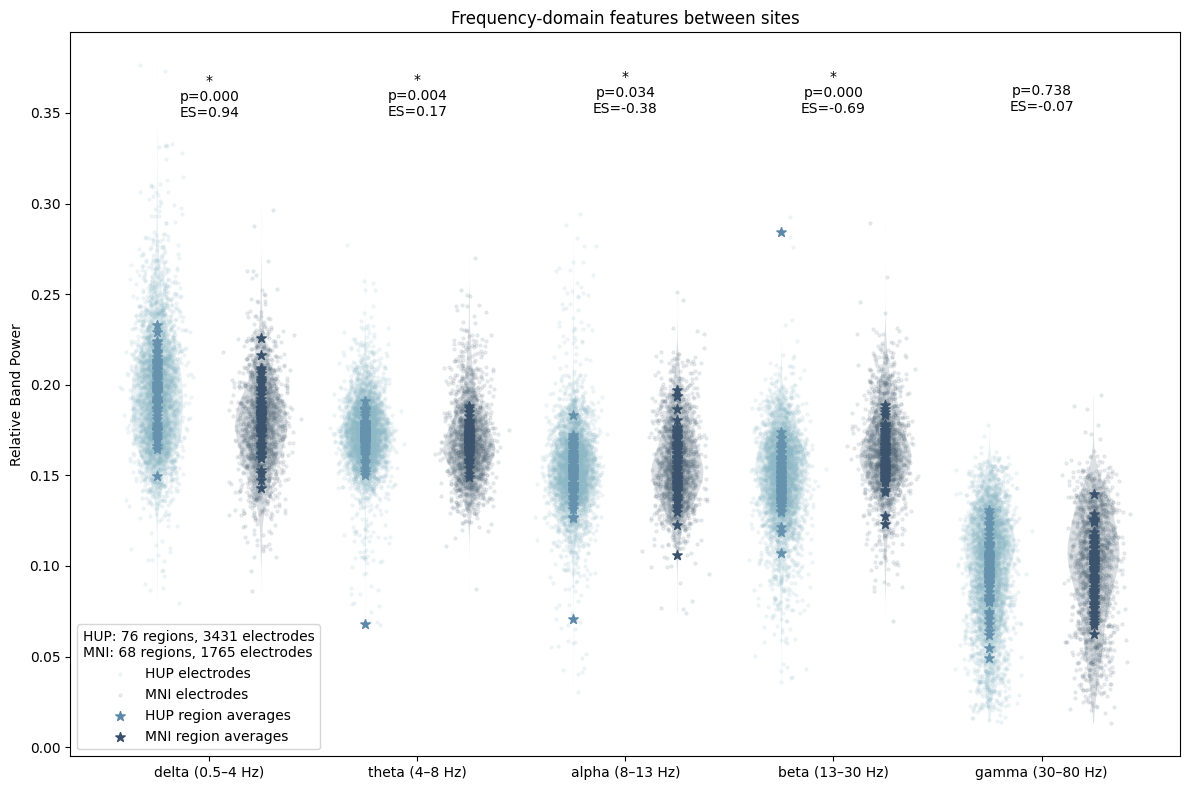


Processing entropy feature: entropy_1min

Processing entropy feature: entropy_fullts


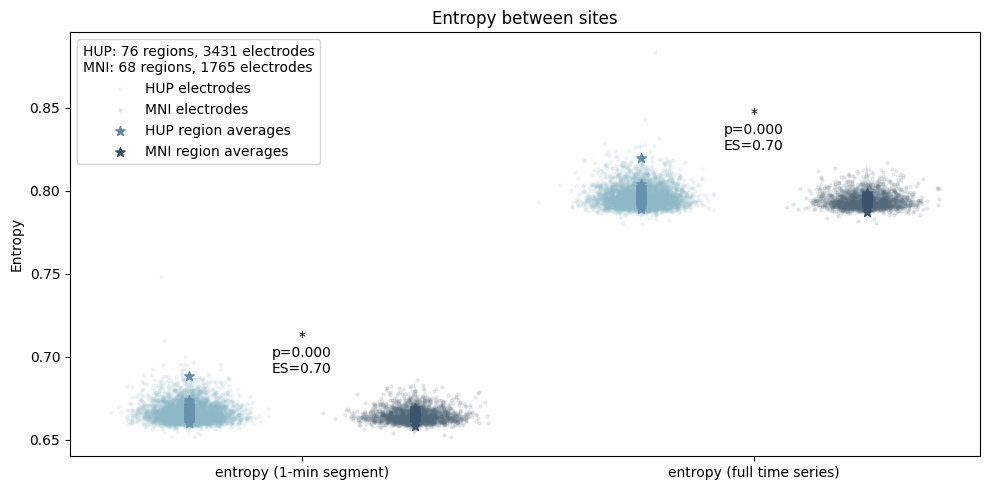

In [115]:
### ADDS SCATTERS

spectral_features = ['deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel']
entropy_features = ['entropy_1min', 'entropy_fullts']

# Verify features exist in all dataframes
print("\nVerifying features in dataframes:")
for df_name, df in [("HUP electrode-level", hup_univar_feats),
                   ("HUP region-averaged", hup_univar_feats_reg_avg),
                   ("MNI region-averaged", mni_univar_feats_reg_avg)]:
    print(f"\n{df_name} features:")
    print(f"Spectral features present: {all(f in df.columns for f in spectral_features)}")
    print(f"Entropy features present: {all(f in df.columns for f in entropy_features)}")
    print("All columns:", df.columns.tolist())

# Then use the plotting function
plot_spectral_and_entropy_features_eld_lvl(
    hup_reg_avg=hup_univar_feats_reg_avg,
    mni_reg_avg=mni_univar_feats_reg_avg,
    hup_electrodes=hup_univar_feats,
    mni_electrodes=mni_univar_feats,
    spectral_features=spectral_features,
    entropy_features=entropy_features
)

Plots - region level

In [116]:
def plot_spectral_features_region_level(hup_reg_avg, mni_reg_avg, spectral_features, entropy_features):
    """
    Plot both spectral and entropy features using region-averaged data with proper text positioning
    """
    feature_mapping = {
        'deltaRel': 'delta (0.5–4 Hz)',
        'thetaRel': 'theta (4–8 Hz)',
        'alphaRel': 'alpha (8–13 Hz)',
        'betaRel': 'beta (13–30 Hz)',
        'gammaRel': 'gamma (30–80 Hz)',
        'entropy_1min': 'entropy (1-min segment)',
        'entropy_fullts': 'entropy (full time series)'
    }

    # Colors
    hup_color = '#8db9c7'  # pastel blue
    mni_color = '#536878'  # deep teal

    def add_statistical_annotation(ax, x_pos, y_max, p_val, effect_size):
        """Helper function to add statistical annotations with proper positioning"""
        significance_level = '*' if p_val < 0.05 else ''
        
        # Get axes bounds
        ymin, ymax = ax.get_ylim()
        y_range = ymax - ymin
        
        # Position text at 95% of the visible range above the highest data point
        text_y = min(ymax - 0.05 * y_range, y_max + 0.1 * y_range)
        
        # Create text with smaller font and tighter spacing
        text = f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}'
        ax.text(x_pos, text_y, text,
                ha='center', va='top',
                fontsize=9,
                linespacing=0.9,
                bbox=dict(facecolor='white', 
                         alpha=0.8,
                         edgecolor='none',
                         pad=1))

    # Spectral Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_title('Frequency-domain features between sites (spatially-averaged)')
    positions = np.arange(len(spectral_features)) * 2 + 1

    for idx, feature in enumerate(spectral_features):
        # Add violin plot showing region-level distribution
        vp_data = [hup_reg_avg[feature].values, mni_reg_avg[feature].values]
        vp = ax.violinplot(vp_data,
                          positions=[positions[idx] - 0.5, positions[idx] + 0.5],
                          showmeans=True)
        
        # Style violins
        for idx_vp, pc in enumerate(vp['bodies']):
            pc.set_facecolor(hup_color if idx_vp == 0 else mni_color)
            pc.set_alpha(0.4)

        # Add individual region points with jitter
        x_hup = np.random.normal(positions[idx] - 0.5, 0.05, size=len(hup_reg_avg[feature]))
        x_mni = np.random.normal(positions[idx] + 0.5, 0.05, size=len(mni_reg_avg[feature]))
        
        ax.scatter(x_hup, hup_reg_avg[feature].values,
                  color=hup_color, alpha=0.6, s=30,
                  label='HUP regions' if idx == 0 else "")
        ax.scatter(x_mni, mni_reg_avg[feature].values,
                  color=mni_color, alpha=0.6, s=30,
                  label='MNI regions' if idx == 0 else "")

        # Find maximum y value for this feature
        y_max = max(
            np.max(hup_reg_avg[feature].values),
            np.max(mni_reg_avg[feature].values)
        )

        # Add statistical annotations
        _, p_val = stats.mannwhitneyu(hup_reg_avg[feature].dropna(), 
                                    mni_reg_avg[feature].dropna())
        effect_size = (np.mean(hup_reg_avg[feature]) - np.mean(mni_reg_avg[feature])) / \
                      np.sqrt((np.var(hup_reg_avg[feature]) + np.var(mni_reg_avg[feature])) / 2)
        
        add_statistical_annotation(ax, positions[idx], y_max, p_val, effect_size)

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in spectral_features])
    ax.set_ylabel('Relative Band Power')
    
    ax.legend(title=(f'HUP: {len(hup_reg_avg)} regions\n'
                    f'MNI: {len(mni_reg_avg)} regions'))

    # Add padding to the top of the plot
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + (ymax - ymin) * 0.15)

    plt.tight_layout()
    plt.show()

    # Entropy Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title('Entropy between sites (spatially-averaged)')
    positions = np.arange(len(entropy_features)) * 2 + 1

    for idx, feature in enumerate(entropy_features):
        # Add violin plot showing region-level distribution
        vp_data = [hup_reg_avg[feature].values, mni_reg_avg[feature].values]
        vp = ax.violinplot(vp_data,
                          positions=[positions[idx] - 0.5, positions[idx] + 0.5],
                          showmeans=True)
        
        # Style violins
        for idx_vp, pc in enumerate(vp['bodies']):
            pc.set_facecolor(hup_color if idx_vp == 0 else mni_color)
            pc.set_alpha(0.4)

        # Add individual region points with jitter
        x_hup = np.random.normal(positions[idx] - 0.5, 0.05, size=len(hup_reg_avg[feature]))
        x_mni = np.random.normal(positions[idx] + 0.5, 0.05, size=len(mni_reg_avg[feature]))
        
        ax.scatter(x_hup, hup_reg_avg[feature].values,
                  color=hup_color, alpha=0.6, s=30,
                  label='HUP regions' if idx == 0 else "")
        ax.scatter(x_mni, mni_reg_avg[feature].values,
                  color=mni_color, alpha=0.6, s=30,
                  label='MNI regions' if idx == 0 else "")

        # Find maximum y value for this feature
        y_max = max(
            np.max(hup_reg_avg[feature].values),
            np.max(mni_reg_avg[feature].values)
        )

        # Add statistical annotations
        _, p_val = stats.mannwhitneyu(hup_reg_avg[feature].dropna(), 
                                    mni_reg_avg[feature].dropna())
        effect_size = (np.mean(hup_reg_avg[feature]) - np.mean(mni_reg_avg[feature])) / \
                      np.sqrt((np.var(hup_reg_avg[feature]) + np.var(mni_reg_avg[feature])) / 2)
        
        add_statistical_annotation(ax, positions[idx], y_max, p_val, effect_size)

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in entropy_features])
    ax.set_ylabel('Entropy')
    ax.legend(title=(f'HUP: {len(hup_reg_avg)} regions\n'
                    f'MNI: {len(mni_reg_avg)} regions'))

    # Add padding to the top of the plot
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + (ymax - ymin) * 0.15)

    plt.tight_layout()
    plt.show()

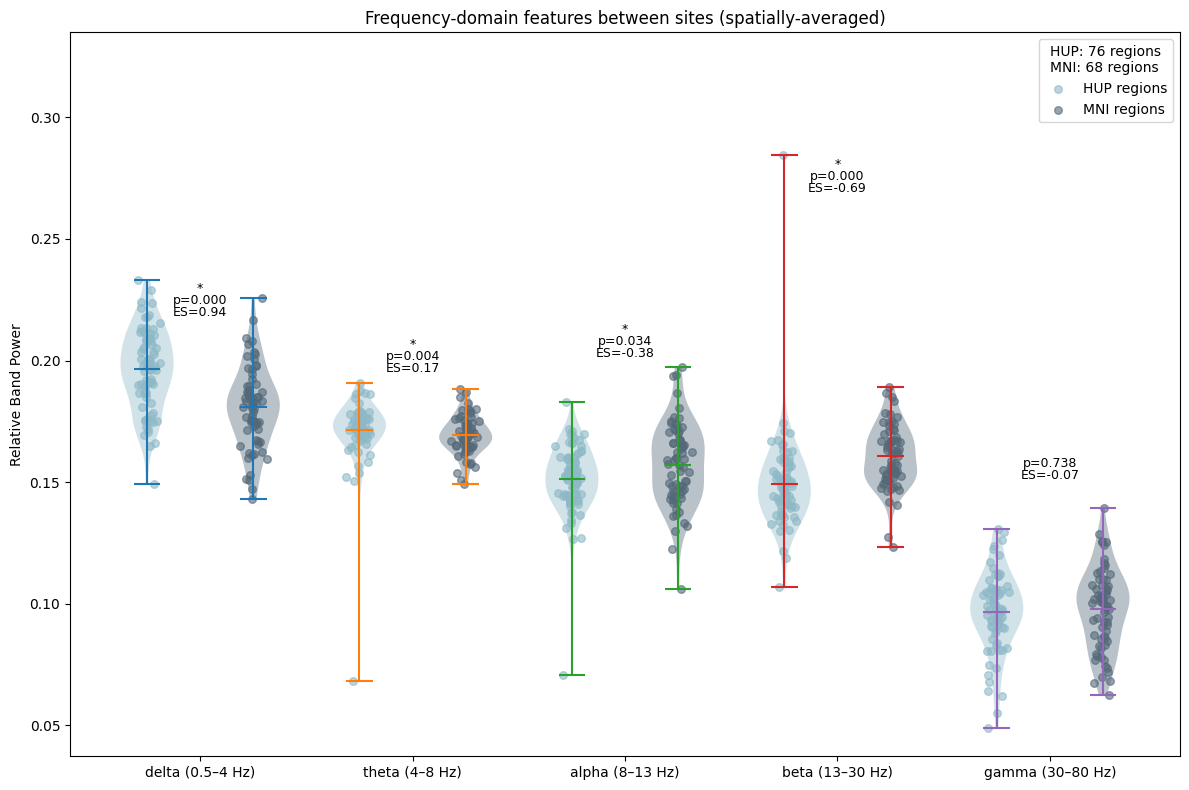

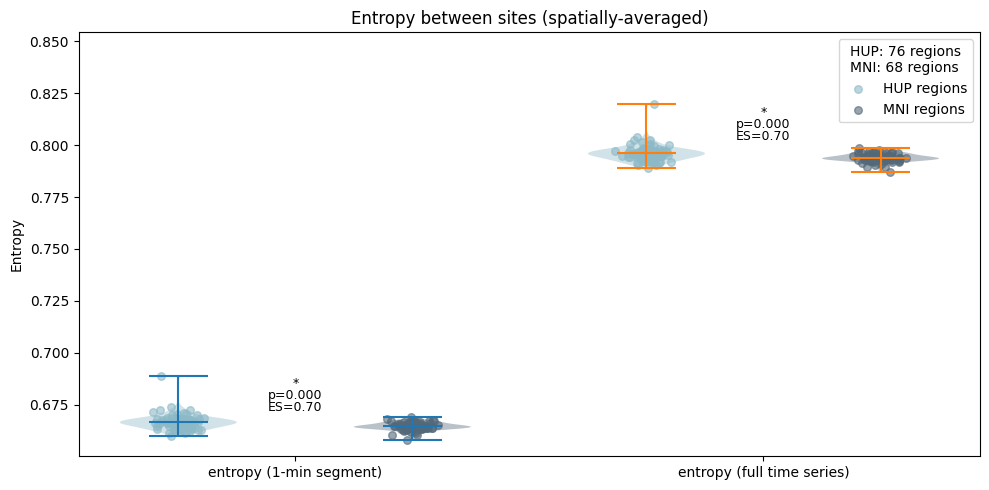

In [117]:
plot_spectral_features_region_level(
    hup_reg_avg=hup_univar_feats_reg_avg,
    mni_reg_avg=mni_univar_feats_reg_avg,
    spectral_features=spectral_features,
    entropy_features=entropy_features
)

Global analysis - results

In [59]:
def print_formatted_results(results_df):
    # Define the output categories
    significant_results = []
    non_significant_results = []
    robust_analysis_count = 0
    
    # Loop through the results DataFrame to categorize and format the output
    for _, row in results_df.iterrows():
        effect_description = "negligible"
        if abs(row['effect_size']) < 0.2:
            effect_description = "negligible"
        elif abs(row['effect_size']) < 0.5:
            effect_description = "small"
        elif abs(row['effect_size']) < 0.8:
            effect_description = "medium"
        else:
            effect_description = "large"

        # Prepare the feature string
        feature_name = row['feature'].capitalize()
        direction = "higher" if row['effect_size'] > 0 else "lower"
        feature_description = f"{feature_name}: {effect_description} effect (HUP {direction}, p={row['p_value']:.2e})"

        # Categorize into significant or non-significant
        if row['p_value_fdr'] < 0.05:
            significant_results.append(feature_description)
            if 'Mann-Whitney' in row['test']:  # Assuming that the test used is stored in the row
                robust_analysis_count += 1
        else:
            non_significant_results.append(f"{feature_name} (p={row['p_value_fdr']:.3f})")

    # Print formatted results
    print("Significant site differences:")
    for result in significant_results:
        print(f" - {result}")
    if non_significant_results:
        print("\nNon-significant features:")
        for result in non_significant_results:
            print(f" - {result}")
    print("\nValidation:")
    print(f" - {robust_analysis_count} features confirmed by robust analysis")
    print(" - Consistent effect sizes across methods")

# Example call to the function (replace 'results_avg' with your actual DataFrame after running your comparison)
results_avg = compare_sites_globally_avg(hup_univar_feats_reg_avg, mni_univar_feats_reg_avg)
print_formatted_results(results_avg)


Significant site differences:
 - Deltarel: large effect (HUP higher, p=1.05e-07)
 - Thetarel: negligible effect (HUP higher, p=3.99e-03)
 - Alpharel: small effect (HUP lower, p=3.41e-02)
 - Betarel: medium effect (HUP lower, p=3.16e-08)
 - Entropy_1min: medium effect (HUP higher, p=2.05e-05)
 - Entropy_fullts: medium effect (HUP higher, p=2.05e-05)

Non-significant features:
 - Gammarel (p=0.678)

Validation:
 - 5 features confirmed by robust analysis
 - Consistent effect sizes across methods


In [60]:
def summarize_results(results_df):
    summary_lines = []

    # Define a mapping from features to more descriptive titles
    feature_descriptions = {
        'deltaRel': 'Low frequencies (delta)',
        'thetaRel': 'Mid frequencies (theta)',
        'alphaRel': 'Mid frequencies (alpha)',
        'betaRel': 'High frequencies (beta)',
        'gammaRel': 'High frequencies (gamma)',
        'entropy_1min': 'Signal complexity (entropy for 1-min segment)',
        'entropy_fullts': 'Signal complexity (entropy for full time series)'
    }

    # Iterate through the DataFrame to create summary lines
    for _, row in results_df.iterrows():
        description = feature_descriptions.get(row['feature'], row['feature'])
        effect_description = interpret_effect_size(row['effect_size'])
        significance_description = interpret_significance(row['p_value_fdr'])
        direction = "HUP > MNI" if row['effect_size'] > 0 else "MNI > HUP"

        if row['p_value_fdr'] < 0.05:
            summary_lines.append(f"{description}: {direction} ({effect_description} effect, {significance_description})")
        else:
            summary_lines.append(f"{description} comparable between sites (p={row['p_value_fdr']:.3f})")

    # Print the summarized lines
    print("Summary of Findings:")
    for line in summary_lines:
        print("- " + line)

summarize_results(results_avg)

Summary of Findings:
- Low frequencies (delta): HUP > MNI (large effect, highly significant)
- Mid frequencies (theta): HUP > MNI (negligible effect, very significant)
- Mid frequencies (alpha): MNI > HUP (small effect, significant)
- High frequencies (beta): MNI > HUP (medium effect, highly significant)
- High frequencies (gamma) comparable between sites (p=0.678)
- Signal complexity (entropy for 1-min segment): HUP > MNI (medium effect, highly significant)
- Signal complexity (entropy for full time series): HUP > MNI (medium effect, highly significant)


REGION-LEVEL ANALYSES

In [61]:
def compare_sites_by_region(hup_region_features, mni_region_features):
   # Track filtering steps
   hup_regions = set(hup_region_features['roi'].unique())
   mni_regions = set(mni_region_features['roi'].unique())
   common_regions = hup_regions.intersection(mni_regions)
   
   print(f"Initial regions:")
   print(f"HUP: {len(hup_regions)}")
   print(f"MNI: {len(mni_regions)}")
   print(f"Common: {len(common_regions)}")
   
   # Track filtered regions
   insufficient_samples = set()
   failed_stats = set()
   
   results = []
   for roi in common_regions:
       hup_roi = hup_region_features[hup_region_features['roi'] == roi]
       mni_roi = mni_region_features[mni_region_features['roi'] == roi]
       
       features = [col for col in hup_roi.columns if col.endswith('_mean')]
       
       for feature in features:
           hup_means = hup_roi.groupby('patient_id')[feature].mean()
           mni_means = mni_roi.groupby('patient_id')[feature].mean()
           
           if len(hup_means) < 5 or len(mni_means) < 5:
               insufficient_samples.add(roi)
               continue
           
           try:
               _, hup_p = stats.shapiro(hup_means)
               _, mni_p = stats.shapiro(mni_means)
               
               if hup_p > 0.05 and mni_p > 0.05:
                   stat, p_val = stats.ttest_ind(hup_means, mni_means)
                   test_name = "t-test"
               else:
                   stat, p_val = stats.mannwhitneyu(hup_means, mni_means,
                                                  alternative='two-sided')
                   test_name = "Mann-Whitney U"
               
               effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
                             np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
               
               results.append({
                   'roi': roi,
                   'feature': feature,
                   'test': test_name,
                   'statistic': stat,
                   'p_value': p_val,
                   'effect_size': effect_size,
                   'hup_mean': np.mean(hup_means),
                   'mni_mean': np.mean(mni_means),
                   'hup_std': np.std(hup_means),
                   'mni_std': np.std(mni_means),
                   'hup_n': len(hup_means),
                   'mni_n': len(mni_means)
               })
           except Exception as e:
               failed_stats.add(roi)
               print(f"Statistical testing failed for {roi}: {str(e)}")
   
   print("\nRegions filtered out:")
   print(f"Insufficient samples (<5 patients): {len(insufficient_samples)}")
   if insufficient_samples:
       print(insufficient_samples)
   print(f"Failed statistical testing: {len(failed_stats)}")
   if failed_stats:
       print(failed_stats)
   
   results_df = pd.DataFrame(results)
   _, fdr_corrected = fdrcorrection(results_df['p_value'])
   results_df['p_value_fdr'] = fdr_corrected
   
   print(f"\nFinal regions included: {len(results_df['roi'].unique())}")
   
   return results_df

In [74]:
regional_results = compare_sites_by_region(hup_univar_feats_reg, mni_univar_feats_reg)

Initial regions:
HUP: 76
MNI: 68
Common: 65

Regions filtered out:
Insufficient samples (<5 patients): 20
{'ctx-lh-transversetemporal', 'ctx-rh-posteriorcingulate', 'ctx-lh-caudalanteriorcingulate', 'Left-Putamen', 'ctx-lh-lingual', 'ctx-lh-paracentral', 'ctx-rh-parahippocampal', 'Left-Amygdala', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-rostralanteriorcingulate', 'Left-Caudate', 'ctx-rh-isthmuscingulate', 'ctx-lh-posteriorcingulate', 'ctx-lh-parsorbitalis', 'ctx-lh-cuneus', 'ctx-lh-pericalcarine', 'ctx-rh-paracentral', 'Right-Amygdala', 'Right-Putamen', 'ctx-rh-parsorbitalis'}
Failed statistical testing: 0

Final regions included: 45


|d| > 0.8: Large effect
0.5 < |d| < 0.8: Medium effect
0.2 < |d| < 0.5: Small effect
|d| < 0.2: Negligible effect

In [75]:
def count_overlapping_regions():
    hup_regions = set(hup_univar_feats_reg['roi'].unique())
    mni_regions = set(mni_univar_feats_reg['roi'].unique())
    common_regions = hup_regions.intersection(mni_regions)
    
    print(f"HUP regions: {len(hup_regions)}")
    print(f"MNI regions: {len(mni_regions)}")
    print(f"Common regions: {len(common_regions)}")
    return common_regions

count_overlapping_regions()

HUP regions: 76
MNI regions: 68
Common regions: 65


{'Left-Amygdala',
 'Left-Caudate',
 'Left-Hippocampus',
 'Left-Putamen',
 'Right-Amygdala',
 'Right-Hippocampus',
 'Right-Putamen',
 'ctx-lh-bankssts',
 'ctx-lh-caudalanteriorcingulate',
 'ctx-lh-caudalmiddlefrontal',
 'ctx-lh-cuneus',
 'ctx-lh-fusiform',
 'ctx-lh-inferiorparietal',
 'ctx-lh-inferiortemporal',
 'ctx-lh-insula',
 'ctx-lh-isthmuscingulate',
 'ctx-lh-lateraloccipital',
 'ctx-lh-lateralorbitofrontal',
 'ctx-lh-lingual',
 'ctx-lh-medialorbitofrontal',
 'ctx-lh-middletemporal',
 'ctx-lh-paracentral',
 'ctx-lh-parsopercularis',
 'ctx-lh-parsorbitalis',
 'ctx-lh-parstriangularis',
 'ctx-lh-pericalcarine',
 'ctx-lh-postcentral',
 'ctx-lh-posteriorcingulate',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-rostralanteriorcingulate',
 'ctx-lh-rostralmiddlefrontal',
 'ctx-lh-superiorfrontal',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-supramarginal',
 'ctx-lh-transversetemporal',
 'ctx-rh-bankssts',
 'ctx-rh-caudalanteriorcingulate',
 'ctx-rh-caudalmiddle

In [63]:
def get_electrode_counts_by_region(df):
    """
    Count number of electrodes per region
    
    Args:
        df: DataFrame with electrode to region mapping containing roiNum column
        
    Returns:
        DataFrame with counts per region
    """
    # Simply count occurrences of each roiNum
    counts = df['roiNum'].value_counts().to_frame('n_electrodes')
    return counts

In [125]:
def convert_roi_name(ctx_name):
    """Convert ctx-style names to abvr style names"""
    # Special cases for hippocampus
    if ctx_name == "Left-Hippocampus":
        return "Hip_L"
    elif ctx_name == "Right-Hippocampus":
        return "Hip_R"
    
    # Remove 'ctx-' prefix
    name = ctx_name.replace('ctx-', '')
    
    # Convert hemisphere prefix
    if name.startswith('lh-'):
        hemi = 'L'
        name = name.replace('lh-', '')
    elif name.startswith('rh-'):
        hemi = 'R'
        name = name.replace('rh-', '')
    else:
        return name
    
    # Convert anatomical names to abbreviations
    name_map = {
        'lateraloccipital': 'LOcc',
        'inferiorparietal': 'InPar',
        'superiortemporal': 'SpTmp',
        'middletemporal': 'MTem',
        'inferiortemporal': 'InTem',
        'fusiform': 'Fusi',
        'precuneus': 'Precu',
        'precentral': 'PreCt',
        'postcentral': 'PsCtr',
        'supramarginal': 'SpMar',
        'parstriangularis': 'ParTrg',
        'parsopercularis': 'ParOpr',
        'parsorbitalis': 'ParOrb',
        'superiorfrontal': 'SpFr',
        'rostralmiddlefrontal': 'RMFr',
        'caudalmiddlefrontal': 'CaMFr',
        'medialorbitofrontal': 'MObFr',
        'lateralorbitofrontal': 'LObFr',
        'insula': 'Ins',
        'bankssts': 'Bkst',
        # Adding missing mappings
        'isthmuscingulate': 'IstCg',
        'superiorparietal': 'SpPr',
        'lingual': 'Ling',
        'rostralanteriorcingulate': 'RACg',
        'caudalanteriorcingulate': 'CaACg',
        'posteriorcingulate': 'PCg'
    }
    
    base_name = name_map.get(name, name)
    if name not in name_map:
        print(f"Warning: No mapping found for {name}")
    return f"{base_name}_{hemi}"

def visualize_regional_differences(results_df, hup_df, mni_df, hup_idx_map_df, mni_idx_map_df):
    # Create region number to name mapping
    region_to_num_map = dict(zip(hup_df['abvr'], hup_df['roiNum']))
    region_to_num_map.update(dict(zip(mni_df['abvr'], mni_df['roiNum'])))
    
    # Print unique region abbreviations for verification
    print("Unique region abbreviations in HUP:", sorted(hup_df['abvr'].unique()))
    print("Unique region abbreviations in MNI:", sorted(mni_df['abvr'].unique()))
        
    # Get electrode counts by region
    hup_counts = hup_df['roiNum'].value_counts()
    mni_counts = mni_df['roiNum'].value_counts()
    
    feature_names = {
        'deltaRel_mean': 'Mean relative power in delta band (0.5-4 Hz)',
        'thetaRel_mean': 'Mean relative power in theta band (4-8 Hz)',
        'alphaRel_mean': 'Mean relative power in alpha band (8-13 Hz)',
        'betaRel_mean': 'Mean relative power in beta band (13-30 Hz)', 
        'gammaRel_mean': 'Mean relative power in gamma band (30-80 Hz)',
        'entropy_1min_mean': 'Mean signal entropy (1-min segment)',
        'entropy_fullts_mean': 'Mean signal entropy (full time series)',
    }
    
    # Sort features alphabetically
    # sorted_features = sorted(feature_names.keys())
    feature_keys = feature_names.keys()
    
    for feature in feature_keys:
        feature_results = results_df[results_df['feature'] == feature].copy()
        feature_results = feature_results.sort_values('effect_size')
        
        plt.figure(figsize=(15, 10))
        
        # Create main axis for effect sizes
        ax1 = plt.gca()
        
        # Plot effect sizes
        bars = ax1.barh(range(len(feature_results)), feature_results['effect_size'])
        
        # Add significance markers
        sig_mask = feature_results['p_value_fdr'] < 0.05
        ax1.plot(feature_results[sig_mask]['effect_size'], 
                np.where(sig_mask)[0], 'r*')
        
        # Add vertical line at x=0
        ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Create labels with electrode counts
        labels = []
        for _, row in feature_results.iterrows():
            roi = row['roi']
            abvr = convert_roi_name(roi)
            
            if abvr in region_to_num_map:
                roi_num = region_to_num_map[abvr]
                hup_n = hup_counts.get(roi_num, 0)
                mni_n = mni_counts.get(roi_num, 0)
            else:
                hup_n = 0
                mni_n = 0
                print(f"Warning: No mapping found for {roi} (converted to {abvr})")
            
            label = f"{roi} (HUP:{int(hup_n)}, MNI:{int(mni_n)})"
            labels.append(label)
        
        # Set y-axis labels
        ax1.set_yticks(range(len(feature_results)))
        ax1.set_yticklabels(labels)
        
        # Set x-axis label and title
        ax1.set_xlabel("Effect Size (Cohen's d)\n← MNI higher | HUP higher →")
        plt.title(f"{feature_names[feature]}")
        
        plt.tight_layout()
        plt.show()

Unique region abbreviations in HUP: ['Acc_R', 'Amy_L', 'Amy_R', 'Bkst_L', 'Bkst_R', 'CaACg_L', 'CaACg_R', 'CaMFr_L', 'CaMFr_R', 'Cau_L', 'Cau_R', 'Cun_L', 'Ethr_L', 'Ethr_R', 'Fpole_L', 'Fusi_L', 'Fusi_R', 'Hip_L', 'Hip_R', 'InPar_L', 'InPar_R', 'InTem_L', 'InTem_R', 'Ins_L', 'Ins_R', 'IstCg_L', 'IstCg_R', 'LObFr_L', 'LObFr_R', 'LOcc_L', 'LOcc_R', 'Ling_L', 'Ling_R', 'MObFr_L', 'MObFr_R', 'MTem_L', 'MTem_R', 'PCg_L', 'PCg_R', 'Pal_L', 'Pal_R', 'ParCnt_L', 'ParCnt_R', 'ParHip_L', 'ParHip_R', 'ParOpr_L', 'ParOpr_R', 'ParOrb_L', 'ParOrb_R', 'ParTrg_L', 'ParTrg_R', 'PerCal_L', 'PreCt_L', 'PreCt_R', 'Precu_L', 'Precu_R', 'PsCtr_L', 'PsCtr_R', 'Put_L', 'Put_R', 'RACg_L', 'RACg_R', 'RMFr_L', 'RMFr_R', 'SpFr_L', 'SpFr_R', 'SpMar_L', 'SpMar_R', 'SpPr_L', 'SpPr_R', 'SpTmp_L', 'SpTmp_R', 'Tha_L', 'Tpole_L', 'Tpole_R', 'TrTem_L']
Unique region abbreviations in MNI: ['Amy_L', 'Amy_R', 'Bkst_L', 'Bkst_R', 'CaACg_L', 'CaACg_R', 'CaMFr_L', 'CaMFr_R', 'Cau_L', 'Cun_L', 'Cun_R', 'Fusi_L', 'Fusi_R', 'Hip

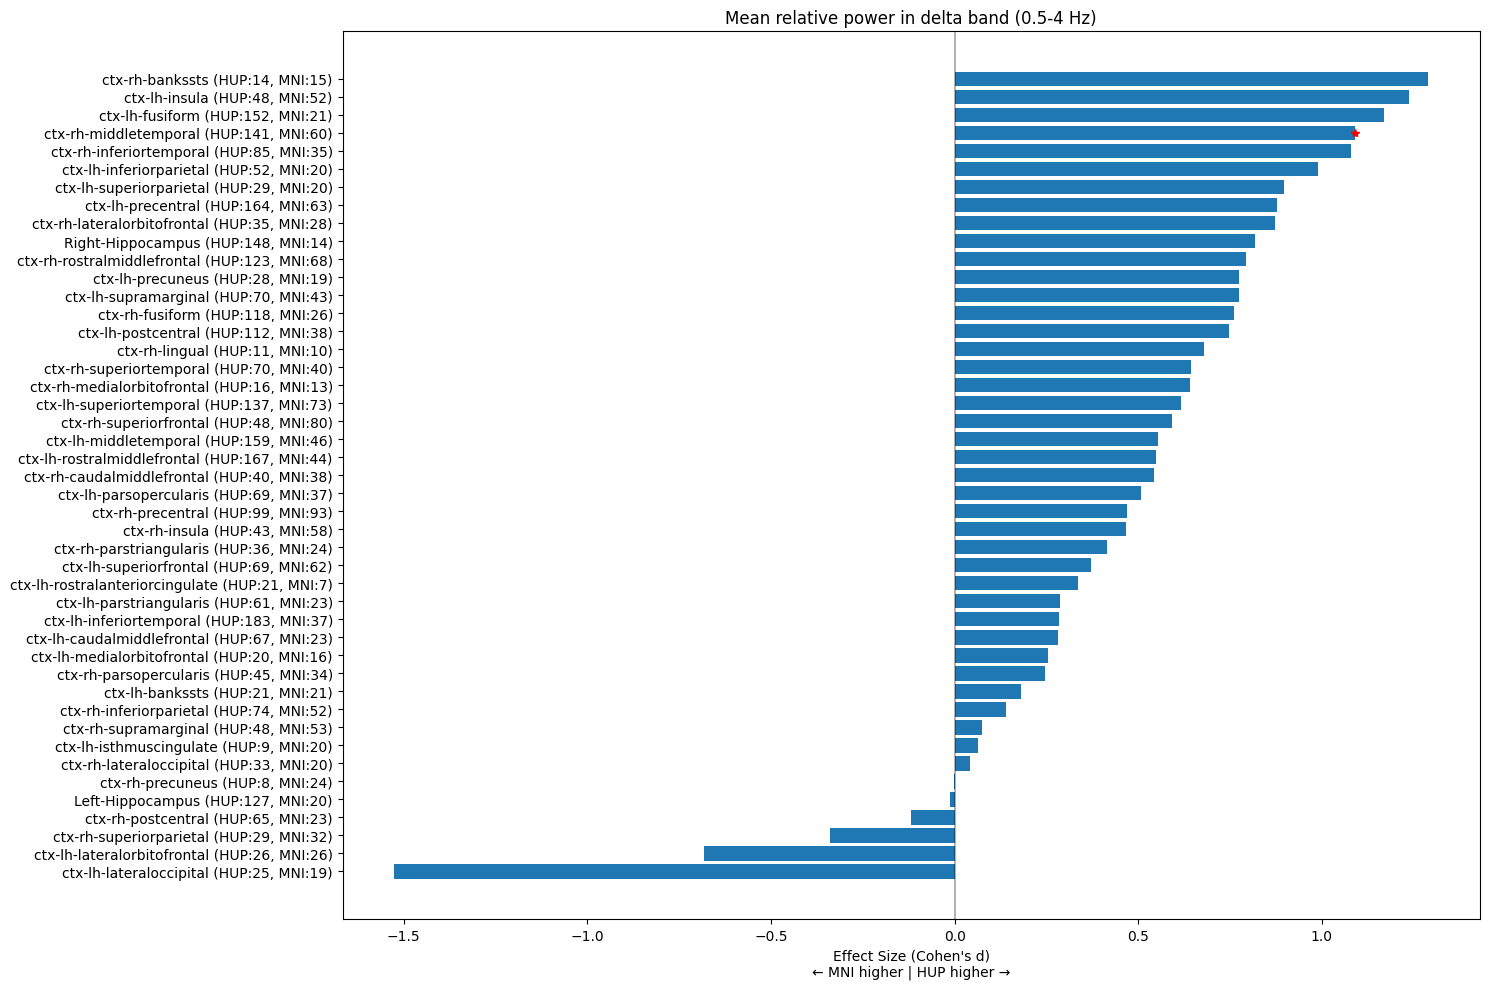

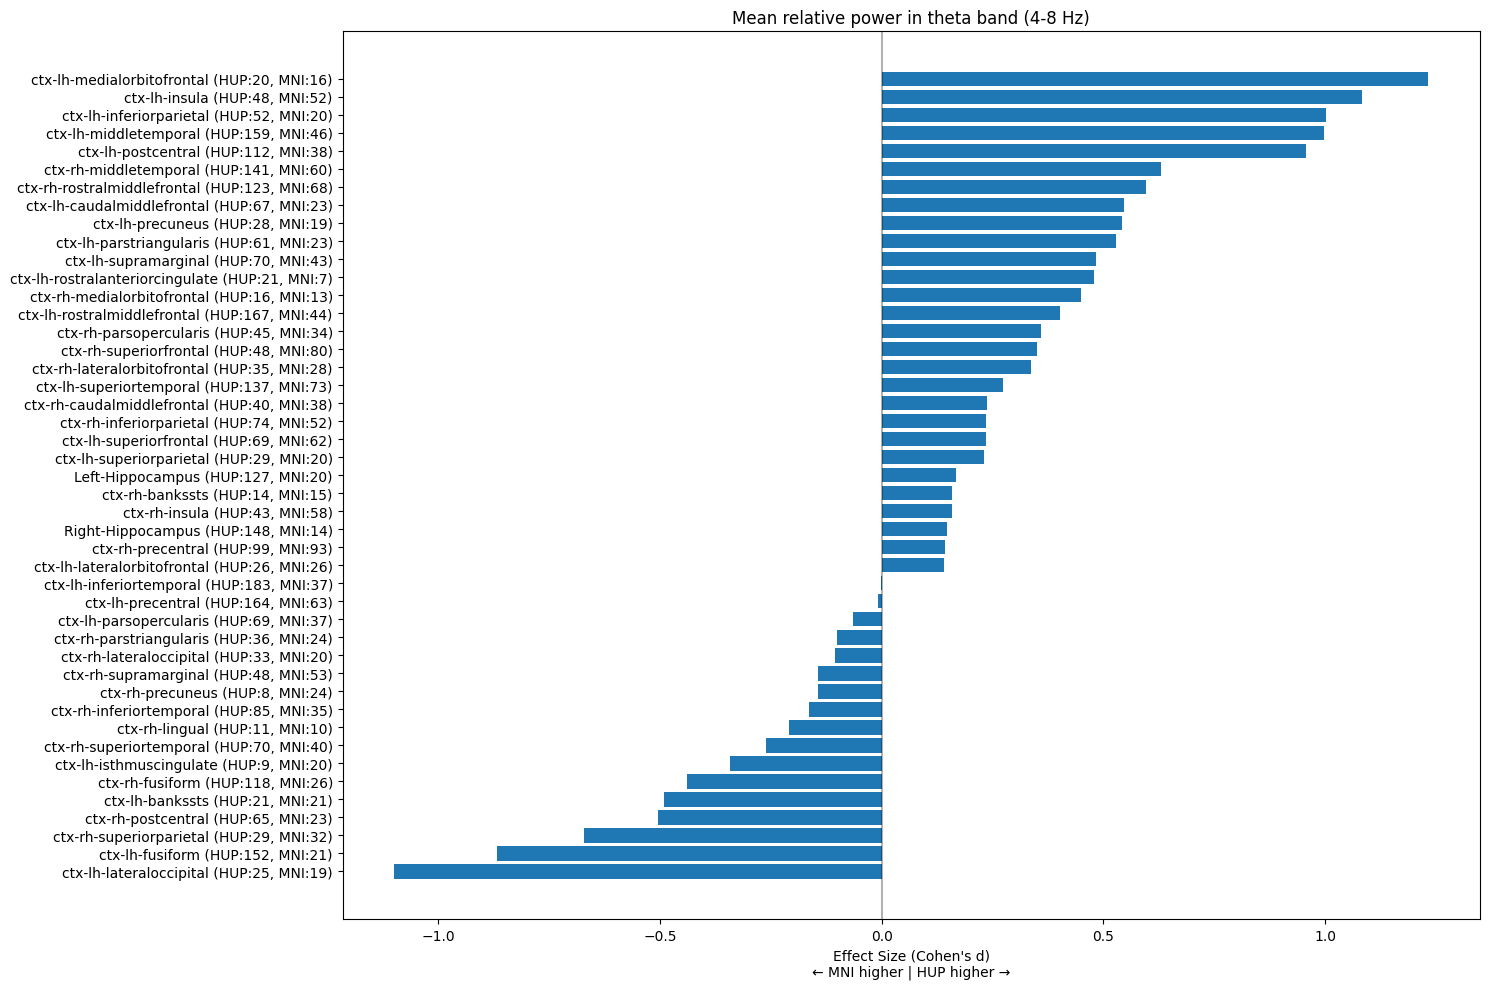

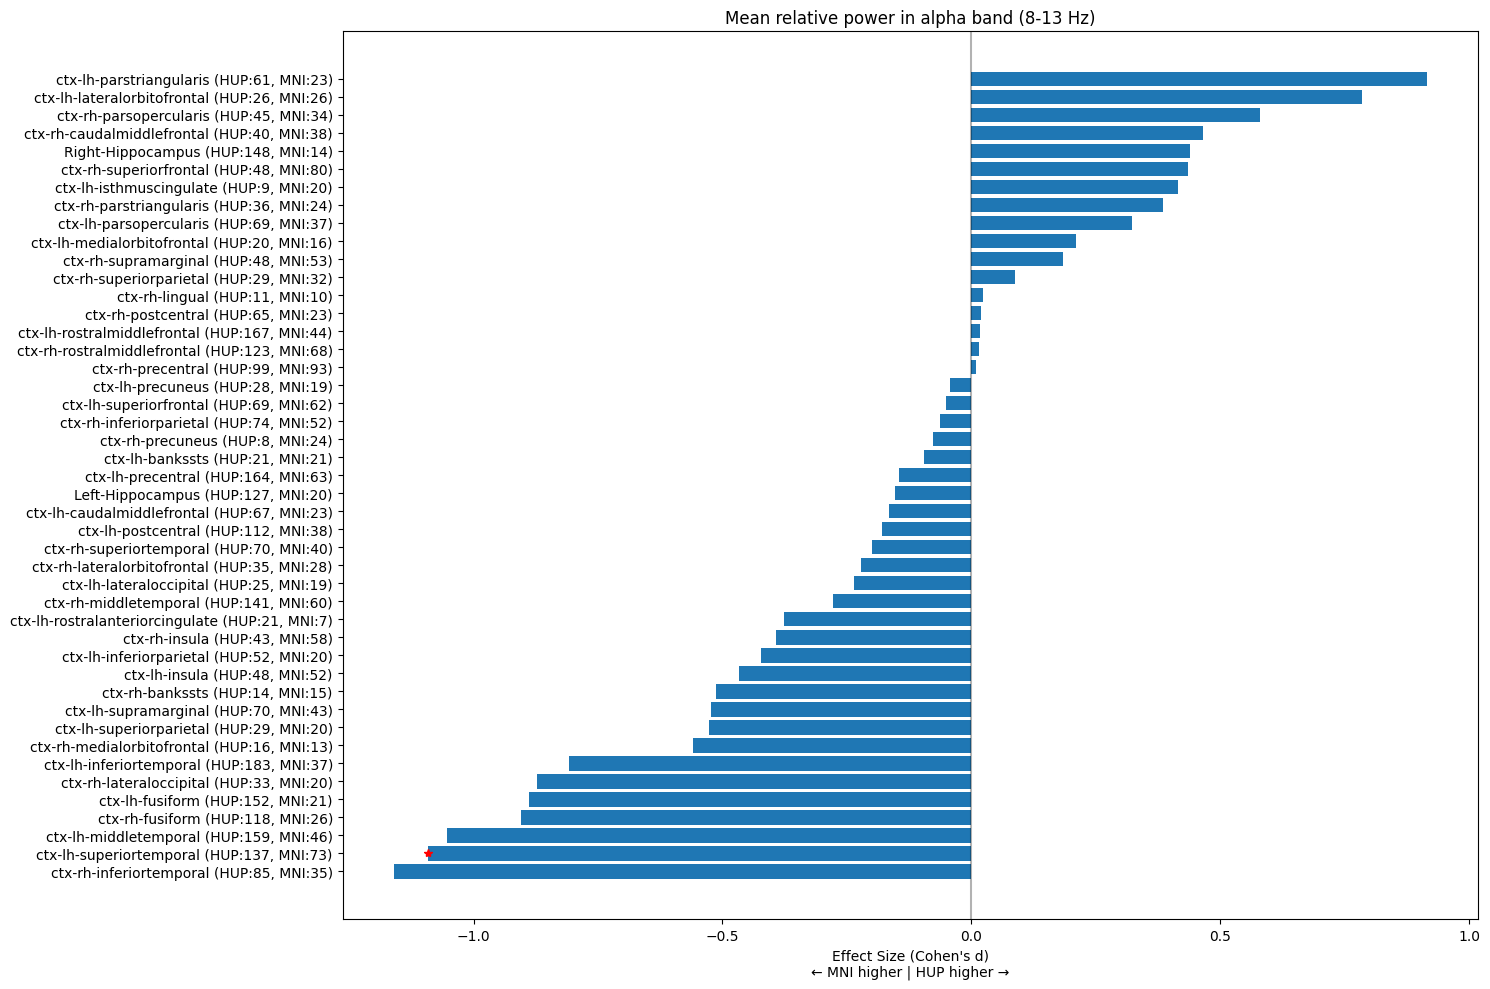

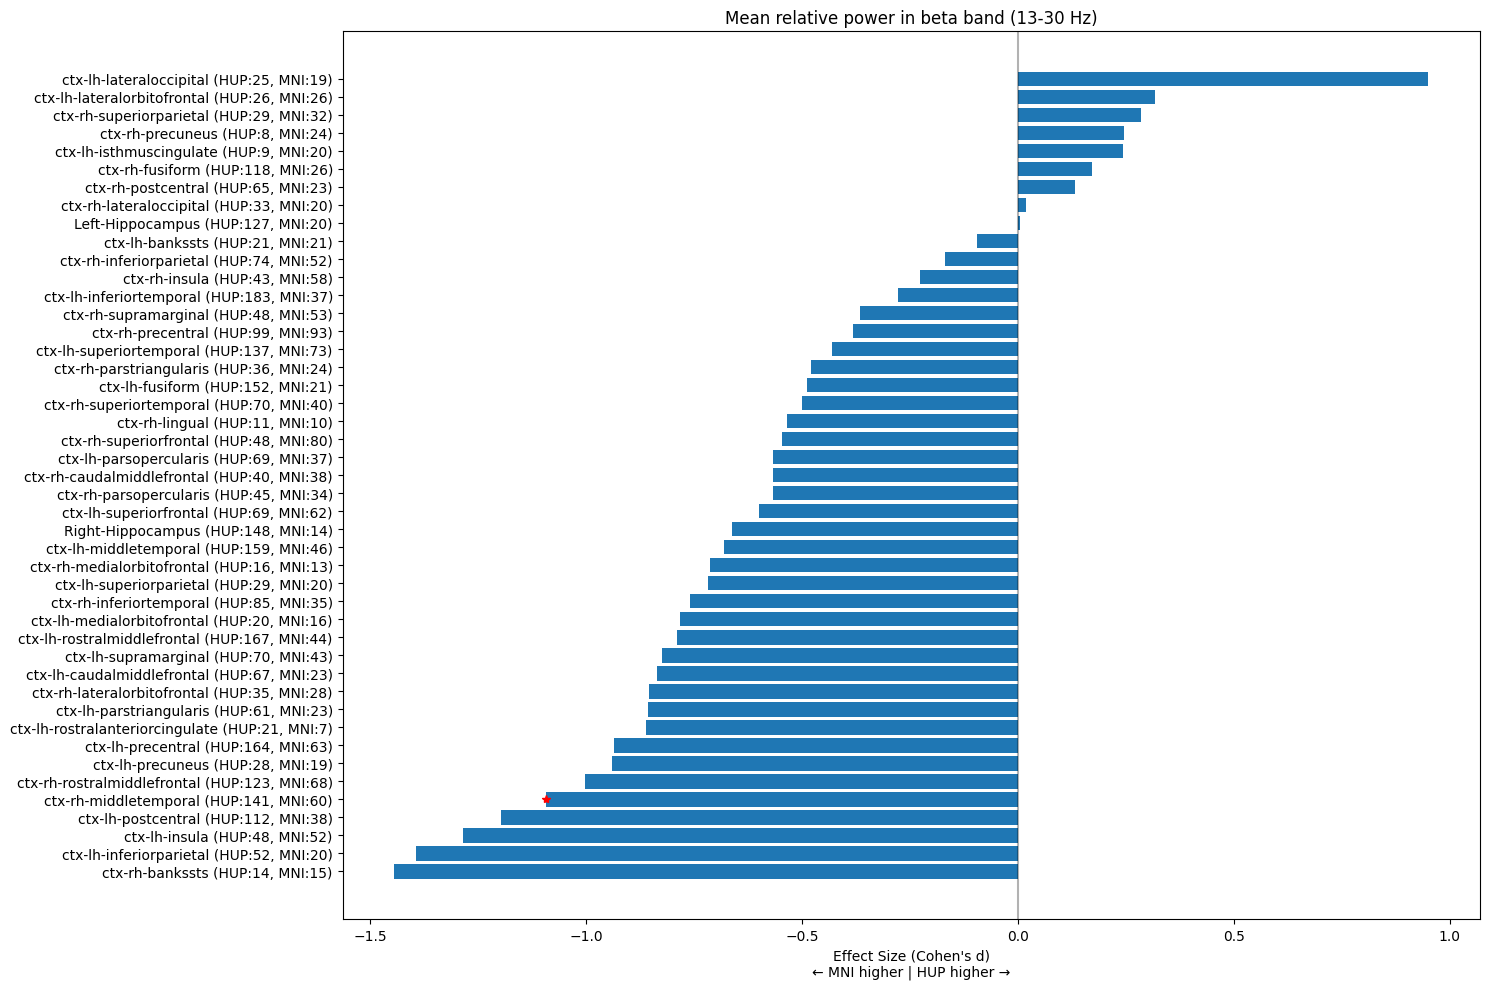

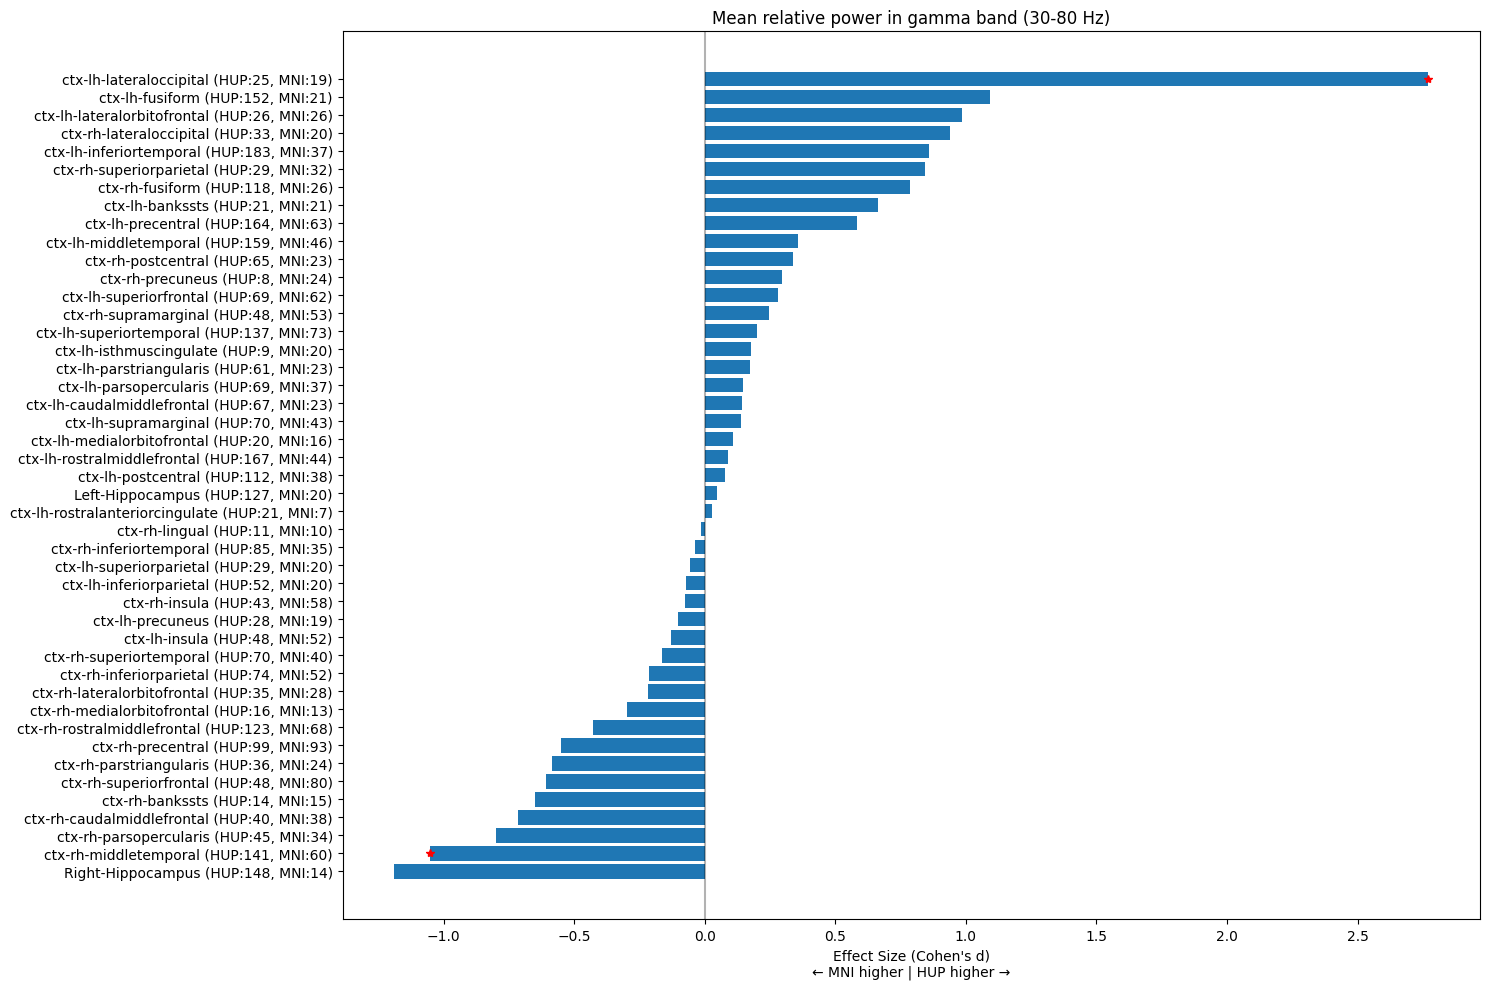

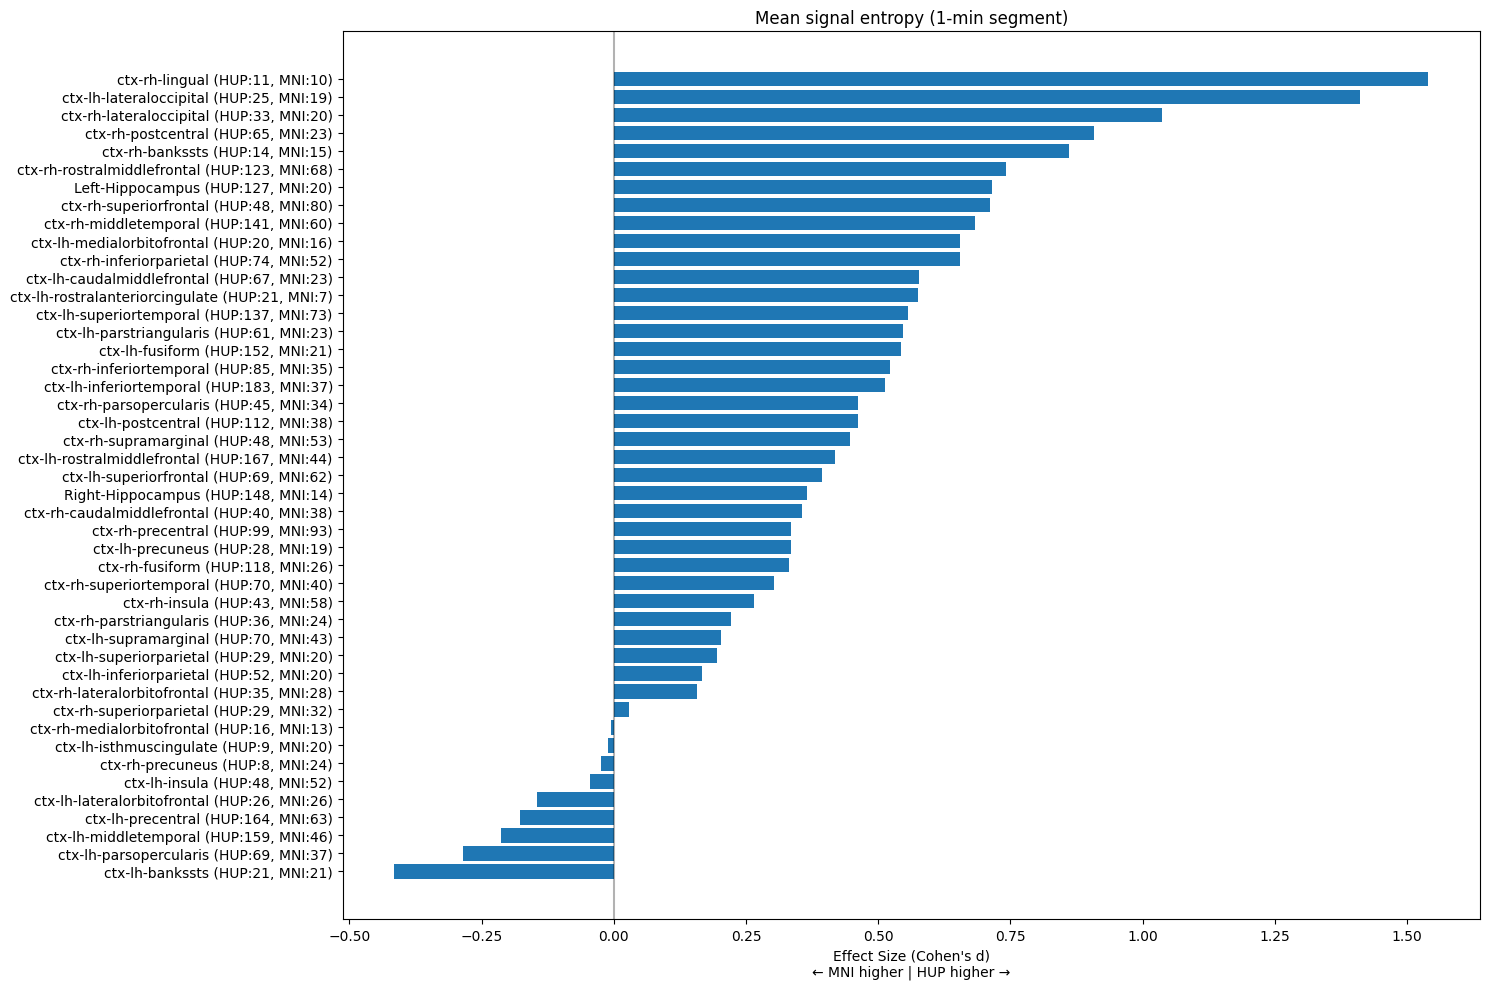

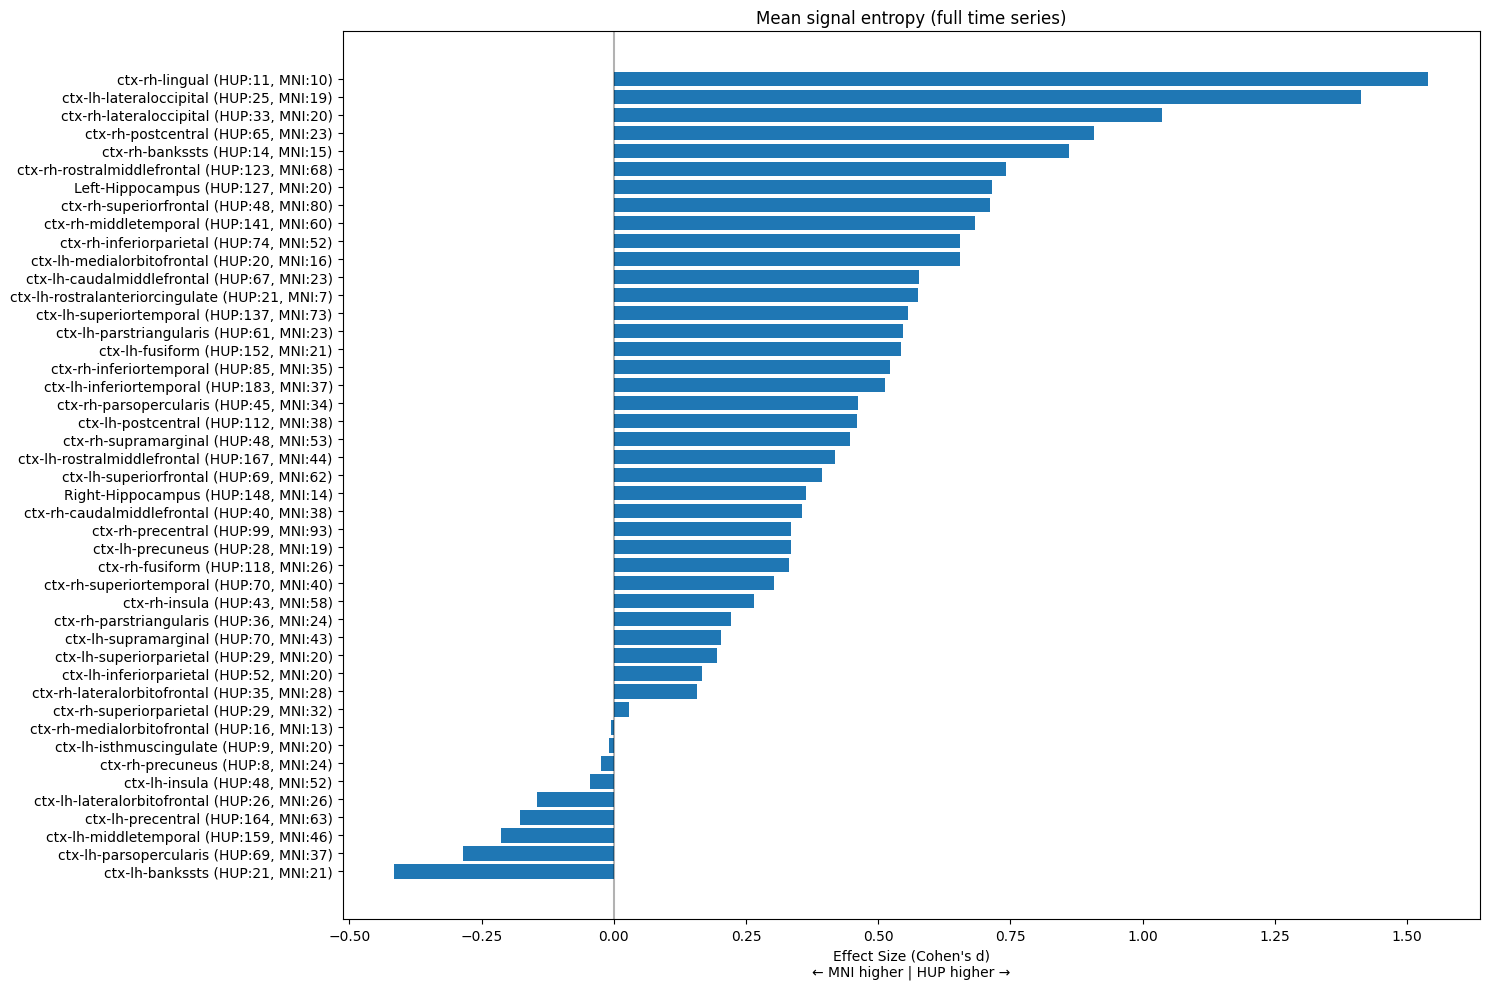

In [126]:
visualize_regional_differences(
    regional_results,
    hup_df,
    mni_df,
    hup_idx_map_arr,
    mni_idx_map_arr
)

In [65]:
def print_regional_summary(results_df, hup_df, mni_df, hup_idx_map_df, mni_idx_map_df):
    """Print summary of findings including electrode counts"""
    print("Regional Analysis Results")
    print("========================")
    
    # Create region number to name mapping
    region_to_num_map = dict(zip(hup_df['abvr'], hup_df['roiNum']))
    region_to_num_map.update(dict(zip(mni_df['abvr'], mni_df['roiNum'])))\
    
    # Get electrode counts by region
    hup_counts = hup_df['roiNum'].value_counts()
    mni_counts = mni_df['roiNum'].value_counts()
    
    for feature in results_df['feature'].unique():
        feature_results = results_df[results_df['feature'] == feature]
        sig_results = feature_results[feature_results['p_value_fdr'] < 0.05]
        
        print(f"\n{feature}:")
        print(f"- {len(sig_results)} regions show significant differences")
        
        if len(sig_results) > 0:
            # Sort by effect size magnitude
            sig_results = sig_results.sort_values('effect_size', key=abs, ascending=False)
            
            print("Top regions with largest differences:")
            for _, row in sig_results.head(3).iterrows():
                roi = row['roi']
                abvr = convert_roi_name(roi)
                
                if abvr in region_to_num_map:
                    roi_num = region_to_num_map[abvr]
                    hup_n = hup_counts.get(roi_num, 0)
                    mni_n = mni_counts.get(roi_num, 0)
                else:
                    hup_n = 0
                    mni_n = 0
                    print(f"Warning: No mapping found for {roi} (converted to {abvr})")
                
                direction = "higher" if row['effect_size'] > 0 else "lower"
                print(f"  * {roi} ({int(hup_n)} HUP electrodes, {int(mni_n)} MNI electrodes): "
                      f"{interpret_effect_size(row['effect_size'])} effect "
                      f"(HUP {direction}, p={row['p_value_fdr']:.3e})")

In [66]:
print_regional_summary(
    regional_results,
    hup_df,
    mni_df,
    hup_idx_map_arr,  
    mni_idx_map_arr   
)

Regional Analysis Results

deltaRel_mean:
- 1 regions show significant differences
Top regions with largest differences:
  * ctx-rh-middletemporal (141 HUP electrodes, 60 MNI electrodes): large effect (HUP higher, p=4.298e-02)

thetaRel_mean:
- 0 regions show significant differences

alphaRel_mean:
- 1 regions show significant differences
Top regions with largest differences:
  * ctx-lh-superiortemporal (137 HUP electrodes, 73 MNI electrodes): large effect (HUP lower, p=4.298e-02)

betaRel_mean:
- 1 regions show significant differences
Top regions with largest differences:
  * ctx-rh-middletemporal (141 HUP electrodes, 60 MNI electrodes): large effect (HUP lower, p=4.771e-02)

gammaRel_mean:
- 2 regions show significant differences
Top regions with largest differences:
  * ctx-lh-lateraloccipital (25 HUP electrodes, 19 MNI electrodes): large effect (HUP higher, p=4.298e-02)
  * ctx-rh-middletemporal (141 HUP electrodes, 60 MNI electrodes): large effect (HUP lower, p=4.298e-02)

entropy

In [68]:
roi = "ParTrg_L"
print(f"\nVerifying counts for {roi}:")
print("HUP count:", len(hup_df[hup_df['abvr'] == roi]))
print("MNI count:", len(mni_df[mni_df['abvr'] == roi]))


Verifying counts for ParTrg_L:
HUP count: 61
MNI count: 23


In [69]:
print("Shape of hup_idx_map_arr:", hup_idx_map_arr.shape if hasattr(hup_idx_map_arr, 'shape') else 'no shape')
print("Type of hup_idx_map_arr:", type(hup_idx_map_arr))

print("\nFirst few values of hup_idx_map_arr:")
print(hup_idx_map_arr[:5] if hasattr(hup_idx_map_arr, '__getitem__') else hup_idx_map_arr)

print("\nShape of mni_idx_map_arr:", mni_idx_map_arr.shape if hasattr(mni_idx_map_arr, 'shape') else 'no shape')
print("Type of mni_idx_map_arr:", type(mni_idx_map_arr))

print("\nFirst few values of mni_idx_map_arr:")
print(mni_idx_map_arr[:5] if hasattr(mni_idx_map_arr, '__getitem__') else mni_idx_map_arr)

print("\nFirst few rows of hup_df:")
print(hup_df.head())

print("\nColumns in regional_results:")
print(regional_results.columns)

Shape of hup_idx_map_arr: (3431, 2)
Type of hup_idx_map_arr: <class 'pandas.core.frame.DataFrame'>

First few values of hup_idx_map_arr:
   Unnamed: 0  0
0           0  1
1           1  1
2           2  1
3           3  1
4           4  1

Shape of mni_idx_map_arr: (1765, 2)
Type of mni_idx_map_arr: <class 'pandas.core.frame.DataFrame'>

First few values of mni_idx_map_arr:
   Unnamed: 0  0
0           0  1
1           1  1
2           2  1
3           3  1
4           4  1

First few rows of hup_df:
          x         y          z  roiNum  snum    abvr         lobe  \
0 -23.43390  39.08790  25.165136    1027    40  RMFr_L      Frontal   
1  21.70795  30.04245  22.902119    2028    75  SpFr_R      Frontal   
2  24.49635  31.18205  26.183199    2027    74  RMFr_R      Frontal   
3  20.94200  14.81145 -13.117785      51    10   Put_R  Subcortical   
4  22.92865  15.07415  -9.786632      51    10   Put_R  Subcortical   

   isSideLeft  
0           1  
1           0  
2           0  
3  

In [70]:
# Create dictionaries for electrode counts
hup_roi_counts = hup_df['roiNum'].value_counts().to_dict()
mni_roi_counts = mni_df['roiNum'].value_counts().to_dict()

# Let's examine a few regions to verify
print("HUP electrode counts for first 5 regions:")
for roi_num in sorted(list(hup_roi_counts.keys()))[:5]:
    roi_info = hup_df[hup_df['roiNum'] == roi_num]['abvr'].iloc[0]
    print(f"Region {roi_num} ({roi_info}): {hup_roi_counts[roi_num]} electrodes")

print("\nMNI electrode counts for first 5 regions:")
for roi_num in sorted(list(mni_roi_counts.keys()))[:5]:
    roi_info = mni_df[mni_df['roiNum'] == roi_num]['abvr'].iloc[0]
    print(f"Region {roi_num} ({roi_info}): {mni_roi_counts[roi_num]} electrodes")

# Also let's verify the total counts match our expectations
print(f"\nTotal HUP electrodes: {sum(hup_roi_counts.values())}")
print(f"Total MNI electrodes: {sum(mni_roi_counts.values())}")

HUP electrode counts for first 5 regions:
Region 10 (Tha_L): 2 electrodes
Region 11 (Cau_L): 9 electrodes
Region 12 (Put_L): 14 electrodes
Region 13 (Pal_L): 2 electrodes
Region 17 (Hip_L): 127 electrodes

MNI electrode counts for first 5 regions:
Region 11 (Cau_L): 3 electrodes
Region 12 (Put_L): 4 electrodes
Region 17 (Hip_L): 20 electrodes
Region 18 (Amy_L): 1 electrodes
Region 51 (Put_R): 1 electrodes

Total HUP electrodes: 3431
Total MNI electrodes: 1765


In [71]:
print("First few rows of results_df:")
print(regional_results.head())

# And let's look at a mapping between region names and roiNums
print("\nMapping between region names and roiNums:")
region_to_num_map = {}
for _, row in hup_df.drop_duplicates('abvr').iterrows():
    region_to_num_map[row['abvr']] = row['roiNum']
print(region_to_num_map)

First few rows of results_df:
             roi        feature            test   statistic   p_value  \
0  ctx-rh-insula  deltaRel_mean          t-test    1.362423  0.182022   
1  ctx-rh-insula  thetaRel_mean  Mann-Whitney U  200.000000  0.235446   
2  ctx-rh-insula  alphaRel_mean          t-test   -1.142730  0.261134   
3  ctx-rh-insula   betaRel_mean  Mann-Whitney U  128.000000  0.289193   
4  ctx-rh-insula  gammaRel_mean  Mann-Whitney U  133.000000  0.367216   

   effect_size  hup_mean  mni_mean   hup_std   mni_std  hup_n  mni_n  \
0     0.467307  0.200804  0.190513  0.018301  0.025199     18     18   
1     0.158536  0.178445  0.174986  0.018668  0.024567     18     18   
2    -0.391953  0.144806  0.150513  0.015574  0.013471     18     18   
3    -0.226899  0.148573  0.154233  0.020499  0.028714     18     18   
4    -0.073745  0.090714  0.092424  0.022134  0.024186     18     18   

   p_value_fdr  
0     0.488334  
1     0.529753  
2     0.563405  
3     0.584102  
4     0.63313

SIGNIFICANT REGIONS

In [137]:
def get_region_info(roi_name, hup_df, mni_df):
    """
    Get region numbers and abbreviations for both datasets
    
    Args:
        roi_name: Name of region (e.g., 'ctx-lh-superiortemporal')
        hup_df: HUP DataFrame with region mappings
        mni_df: MNI DataFrame with region mappings
    
    Returns:
        dict with region information
    """
    abvr = convert_roi_name(roi_name)
    
    # Get roiNum for this region
    hup_roi_info = hup_df[hup_df['abvr'] == abvr]
    mni_roi_info = mni_df[mni_df['abvr'] == abvr]
    
    return {
        'abvr': abvr,
        'hup_roi_num': hup_roi_info['roiNum'].iloc[0] if len(hup_roi_info) > 0 else None,
        'mni_roi_num': mni_roi_info['roiNum'].iloc[0] if len(mni_roi_info) > 0 else None
    }

def get_electrode_data(roi_num, features_df, df):
    """
    Get electrode data and counts for a specific region
    
    Args:
        roi_num: Region number
        features_df: DataFrame with electrode features
        df: DataFrame with electrode mappings
    
    Returns:
        dict with electrode data and counts
    """
    if roi_num is None:
        return {
            'electrode_data': np.array([]),
            'n_electrodes': 0,
            'n_patients': 0
        }
    
    # Get electrodes for this region
    region_mask = df['roiNum'] == roi_num
    electrodes = df[region_mask]
    
    # Get feature values
    electrode_data = features_df.iloc[electrodes.index]
    
    # Get patient counts using snum (subject number)
    n_patients = len(electrodes['snum'].unique())
    
    return {
        'electrode_data': electrode_data,
        'n_electrodes': len(electrodes),
        'n_patients': n_patients
    }

In [138]:
def get_patient_mappings(hup_atlas, mni_atlas, hup_df, mni_df):
    """
    Create mappings between electrodes and patients using atlas data
    
    Args:
        hup_atlas, mni_atlas: Original atlas DataFrames with patient info
        hup_df, mni_df: DataFrames with region mappings
        
    Returns:
        dict with electrode to patient mappings
    """
    # Extract patient numbers for each electrode from atlas data
    hup_patients = pd.DataFrame({
        'electrode_idx': range(len(hup_atlas['patient_no'])),
        'patient_id': hup_atlas['patient_no'].flatten()
    })
    
    mni_patients = pd.DataFrame({
        'electrode_idx': range(len(mni_atlas['Patient'])),
        'patient_id': mni_atlas['Patient'].flatten()
    })
    
    return {
        'hup': hup_patients,
        'mni': mni_patients
    }

def get_electrode_data(roi_num, features_df, df, patient_mapping):
    """
    Get electrode data and counts for a specific region with correct patient mapping
    
    Args:
        roi_num: Region number
        features_df: DataFrame with electrode features
        df: DataFrame with electrode mappings
        patient_mapping: DataFrame with electrode to patient mappings
    
    Returns:
        dict with electrode data and counts
    """
    if roi_num is None:
        return {
            'electrode_data': np.array([]),
            'n_electrodes': 0,
            'n_patients': 0,
            'patient_ids': []
        }
    
    # Get electrodes for this region
    region_mask = df['roiNum'] == roi_num
    electrodes = df[region_mask]
    
    # Get patient IDs using electrode indices
    patient_ids = patient_mapping.loc[electrodes.index, 'patient_id']
    
    # Get feature values
    electrode_data = features_df.iloc[electrodes.index]
    
    return {
        'electrode_data': electrode_data,
        'n_electrodes': len(electrodes),
        'n_patients': len(patient_ids.unique()),
        'patient_ids': sorted(patient_ids.unique())
    }

def verify_region_counts(roi_name, hup_df, mni_df, hup_atlas, mni_atlas):
    """
    Print verification information for a region using correct patient mapping
    """
    # Get patient mappings
    mappings = get_patient_mappings(hup_atlas, mni_atlas, hup_df, mni_df)
    
    region_info = get_region_info(roi_name, hup_df, mni_df)
    print(f"\nVerification for {roi_name}:")
    print(f"Abbreviation: {region_info['abvr']}")
    
    if region_info['hup_roi_num'] is not None:
        hup_mask = hup_df['roiNum'] == region_info['hup_roi_num']
        electrodes = hup_df[hup_mask]
        patient_ids = mappings['hup'].loc[electrodes.index, 'patient_id']
        
        print(f"\nHUP:")
        print(f"ROI number: {region_info['hup_roi_num']}")
        print(f"Total electrodes: {len(electrodes)}")
        print(f"Unique patients: {len(patient_ids.unique())}")
        print(f"Patient numbers: {sorted(patient_ids.unique())}")
    
    if region_info['mni_roi_num'] is not None:
        mni_mask = mni_df['roiNum'] == region_info['mni_roi_num']
        electrodes = mni_df[mni_mask]
        patient_ids = mappings['mni'].loc[electrodes.index, 'patient_id']
        
        print(f"\nMNI:")
        print(f"ROI number: {region_info['mni_roi_num']}")
        print(f"Total electrodes: {len(electrodes)}")
        print(f"Unique patients: {len(patient_ids.unique())}")
        print(f"Patient numbers: {sorted(patient_ids.unique())}")

In [140]:
def create_regional_comparison_plots(results_df, hup_df, mni_df, hup_features, mni_features, hup_atlas, mni_atlas):
    """
    Create violin plots using raw electrode-level data and correct patient mapping
    
    Args:
        results_df: DataFrame with statistical results
        hup_df, mni_df: DataFrames with region mappings
        hup_features, mni_features: DataFrames with electrode features
        hup_atlas, mni_atlas: Original atlas DataFrames with patient info
    """
    # Get patient mappings
    mappings = get_patient_mappings(hup_atlas, mni_atlas, hup_df, mni_df)
    
    # Add roiNum to features DataFrames
    hup_features = hup_features.copy()
    mni_features = mni_features.copy()
    hup_features.reset_index(drop=True, inplace=True)
    mni_features.reset_index(drop=True, inplace=True)
    
    # Get significant regions
    sig_results = results_df[results_df['p_value_fdr'] < 0.05].copy()
    
    # feature_names = {
    #     'gammaRel': 'Gamma band (30-80 Hz)',
    #     'betaRel': 'Beta band (13-30 Hz)',
    #     'alphaRel': 'Alpha band (8-13 Hz)',
    #     'thetaRel': 'Theta band (4-8 Hz)',
    #     'deltaRel': 'Delta band (0.5-4 Hz)',
    #     'entropy_1min': 'Signal entropy (1-min)',
    #     'entropy_fullts': 'Signal entropy (full time series)'
    # }

    feature_names = {
        'deltaRel': 'Delta band (0.5-4 Hz)',
        'thetaRel': 'Theta band (4-8 Hz)',
        'alphaRel': 'Alpha band (8-13 Hz)',
        'betaRel': 'Beta band (13-30 Hz)',
        'gammaRel': 'Gamma band (30-80 Hz)',
        # 'entropy_1min': 'Signal entropy (1-min)',
        # 'entropy_fullts': 'Signal entropy (full time series)'
    }
    
    # for feature in sig_results['feature'].unique():
    #     feature_base = feature.replace('_mean', '')
    #     feature_sig = sig_results[sig_results['feature'] == feature]
    #     n_regions = len(feature_sig)

    for feature_base in feature_names.keys():
        feature = feature_base + '_mean'  # features suffixed with '_mean' in results_df
        if feature in sig_results['feature'].values:
            feature_sig = sig_results[sig_results['feature'] == feature]
            n_regions = len(feature_sig)
        
        if n_regions > 0:
            plt.figure(figsize=(15, 5 * n_regions))
            
            for idx, (_, row) in enumerate(feature_sig.iterrows()):
                plt.subplot(n_regions, 1, idx + 1)
                
                roi = row['roi']
                abvr = convert_roi_name(roi)
                
                # Get roiNum for this region
                hup_roi_info = hup_df[hup_df['abvr'] == abvr]
                mni_roi_info = mni_df[mni_df['abvr'] == abvr]
                
                if len(hup_roi_info) > 0:
                    hup_roi_num = hup_roi_info['roiNum'].iloc[0]
                    # Get all electrodes in this region
                    hup_mask = hup_df['roiNum'] == hup_roi_num
                    hup_electrodes = hup_df[hup_mask]
                    # Get feature values
                    hup_roi_data = hup_features.iloc[hup_electrodes.index][feature_base].values
                    # Get patient IDs using mappings
                    hup_patient_ids = mappings['hup'].loc[hup_electrodes.index, 'patient_id']
                    hup_n_electrodes = len(hup_electrodes)
                    hup_n_patients = len(hup_patient_ids.unique())
                else:
                    hup_roi_data = np.array([])
                    hup_n_electrodes = 0
                    hup_n_patients = 0
                
                if len(mni_roi_info) > 0:
                    mni_roi_num = mni_roi_info['roiNum'].iloc[0]
                    mni_mask = mni_df['roiNum'] == mni_roi_num
                    mni_electrodes = mni_df[mni_mask]
                    mni_roi_data = mni_features.iloc[mni_electrodes.index][feature_base].values
                    mni_patient_ids = mappings['mni'].loc[mni_electrodes.index, 'patient_id']
                    mni_n_electrodes = len(mni_electrodes)
                    mni_n_patients = len(mni_patient_ids.unique())
                else:
                    mni_roi_data = np.array([])
                    mni_n_electrodes = 0
                    mni_n_patients = 0
                
                if len(hup_roi_data) > 0 and len(mni_roi_data) > 0:
                    # Create violin plot
                    vp = plt.violinplot([hup_roi_data, mni_roi_data], 
                                      positions=[1, 2],
                                      showmeans=False,
                                      showextrema=False)
                    
                    # Customize violin colors
                    vp['bodies'][0].set_facecolor('lightblue')
                    vp['bodies'][1].set_facecolor('lightcoral')
                    for pc in vp['bodies']:
                        pc.set_alpha(0.7)
                    
                    # Add median lines
                    plt.hlines(np.median(hup_roi_data), 0.75, 1.25, color='blue', linestyle='-')
                    plt.hlines(np.median(mni_roi_data), 1.75, 2.25, color='red', linestyle='-')
                    
                    # Add individual points with jitter
                    x_jitter = np.random.normal(0, 0.04, size=len(hup_roi_data))
                    plt.scatter(1 + x_jitter, hup_roi_data,
                              alpha=0.6, color='blue', label='HUP electrodes')
                    
                    x_jitter = np.random.normal(0, 0.04, size=len(mni_roi_data))
                    plt.scatter(2 + x_jitter, mni_roi_data,
                              alpha=0.6, color='red', label='MNI electrodes')
                    
                    # Customize plot
                    plt.title(f"{roi.replace('ctx-', '')}\nEffect Size: {row['effect_size']:.2f}, p={row['p_value_fdr']:.2e}")
                    plt.xticks([1, 2], ['HUP', 'MNI'])
                    plt.ylabel('relative power' if 'Rel' in feature else 'entropy')
                    
                    # Add counts with correct patient numbers
                    plt.text(0.02, 0.98, 
                            f'HUP: {hup_n_electrodes} electrodes from {hup_n_patients} patients\n' +
                            f'MNI: {mni_n_electrodes} electrodes from {mni_n_patients} patients',
                            transform=plt.gca().transAxes,
                            verticalalignment='top')
                    
                    plt.text(0.98, 0.98,
                            f'HUP: {np.mean(hup_roi_data):.3f} ± {np.std(hup_roi_data):.3f}\n' +
                            f'MNI: {np.mean(mni_roi_data):.3f} ± {np.std(mni_roi_data):.3f}',
                            transform=plt.gca().transAxes,
                            verticalalignment='top',
                            horizontalalignment='right')
                    
                    plt.grid(True, alpha=0.3)
                    plt.legend()
            
            plt.suptitle(feature_names.get(feature_base, feature_base))
            plt.tight_layout()
            plt.show()

In [96]:
# verify_region_counts('ctx-lh-superiortemporal', hup_df, mni_df)
verify_region_counts('ctx-lh-superiortemporal', hup_df, mni_df, hup_atlas, mni_atlas)


Verification for ctx-lh-superiortemporal:
Abbreviation: SpTmp_L

HUP:
ROI number: 1030
Total electrodes: 137
Unique patients: 33
Patient numbers: [np.uint8(2), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(22), np.uint8(24), np.uint8(26), np.uint8(27), np.uint8(28), np.uint8(30), np.uint8(36), np.uint8(39), np.uint8(44), np.uint8(47), np.uint8(48), np.uint8(49), np.uint8(50), np.uint8(51), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(59), np.uint8(60)]

MNI:
ROI number: 1030
Total electrodes: 73
Unique patients: 20
Patient numbers: [np.uint8(1), np.uint8(4), np.uint8(5), np.uint8(13), np.uint8(17), np.uint8(18), np.uint8(24), np.uint8(29), np.uint8(34), np.uint8(36), np.uint8(37), np.uint8(40), np.uint8(41), np.uint8(44), np.uint8(48), np.uint8(70), np.uint8(82), np.uint8(84), np.uint8(85), np.uint8(89)]


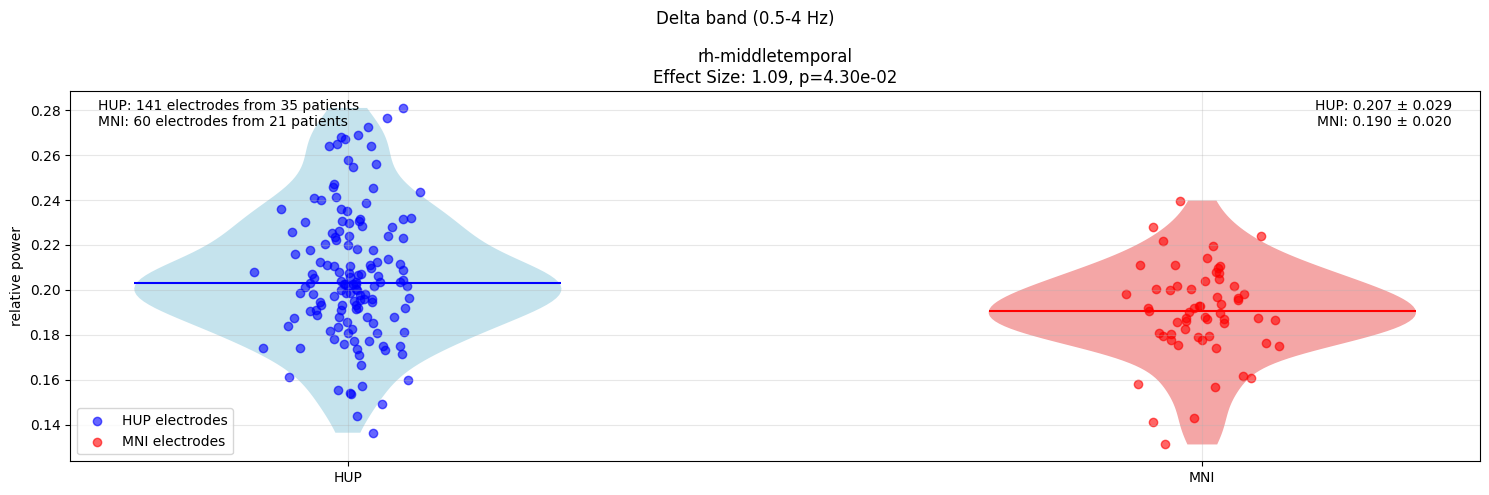

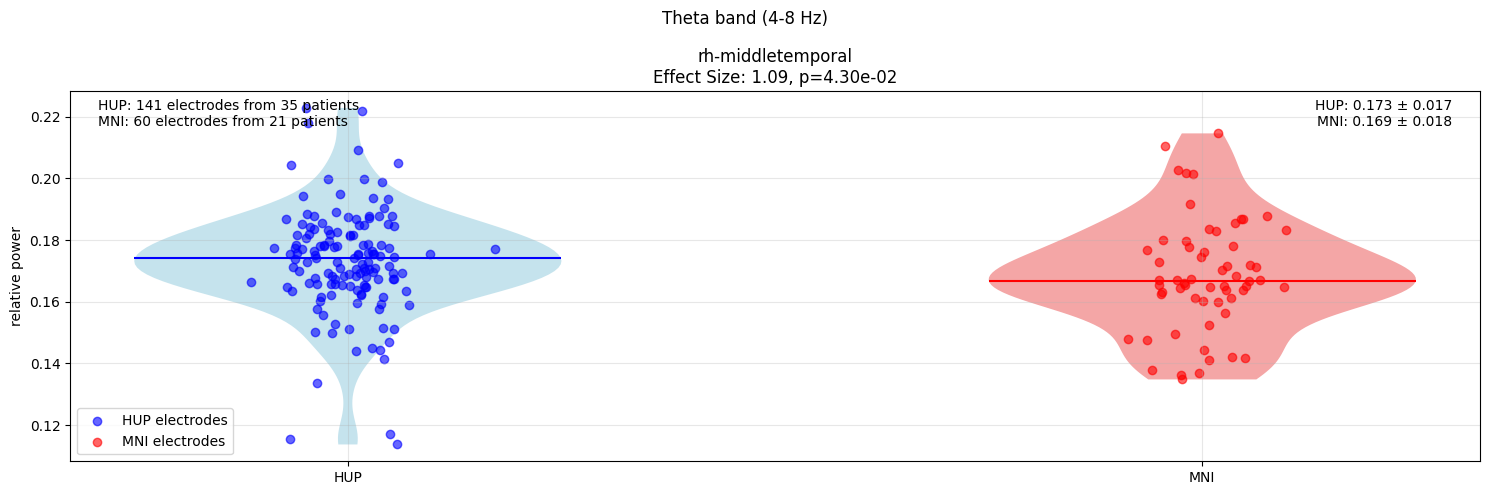

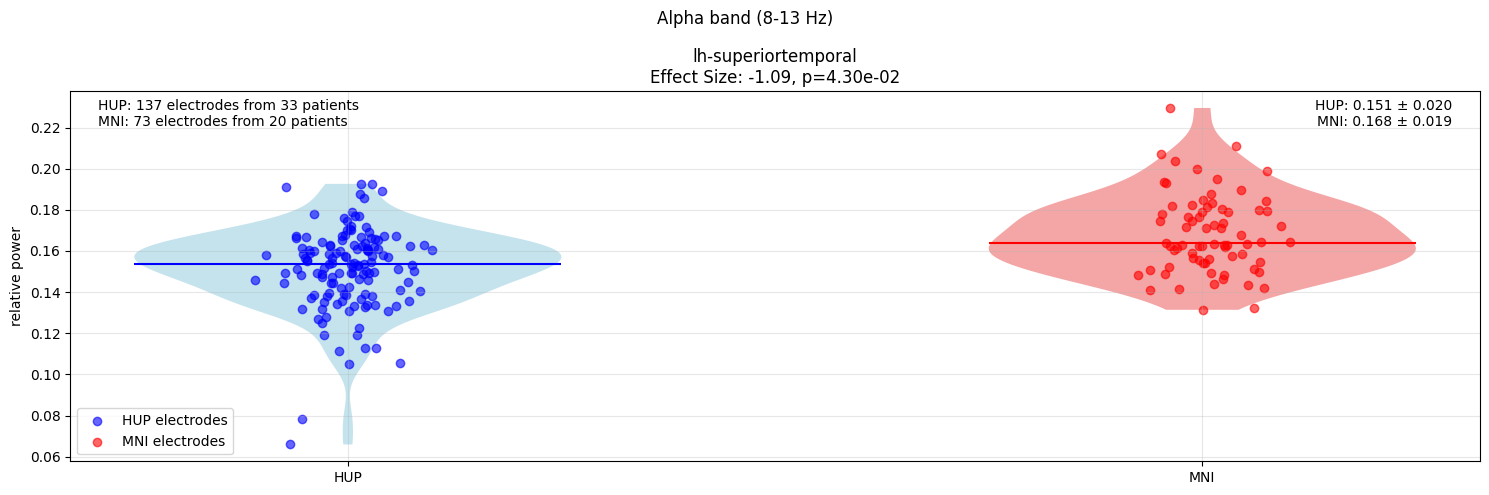

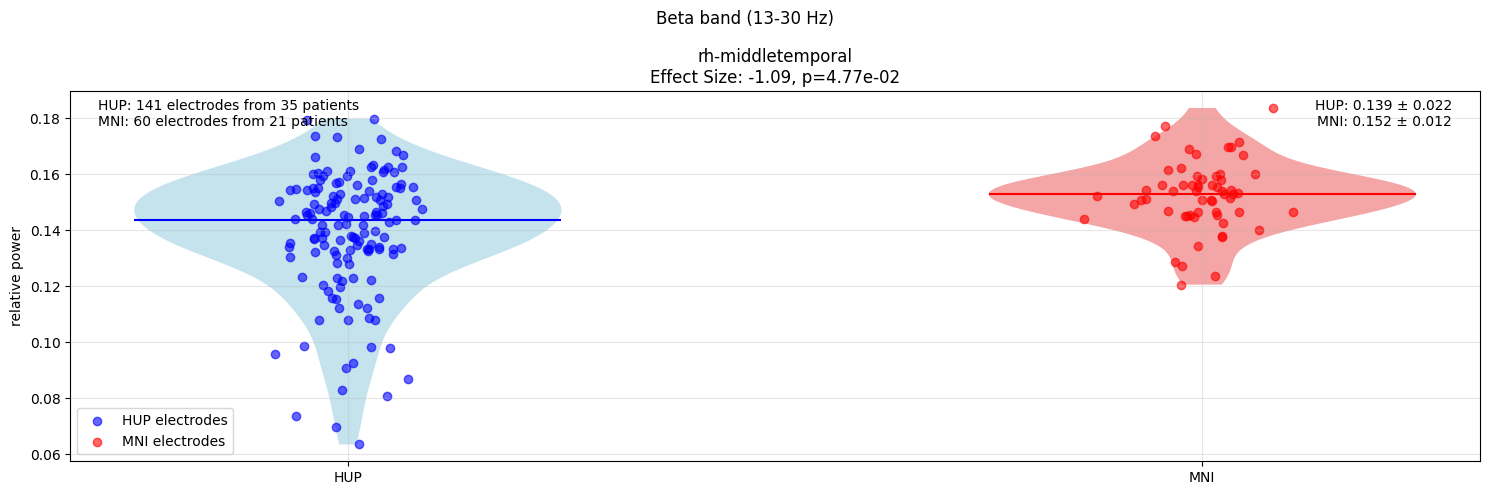

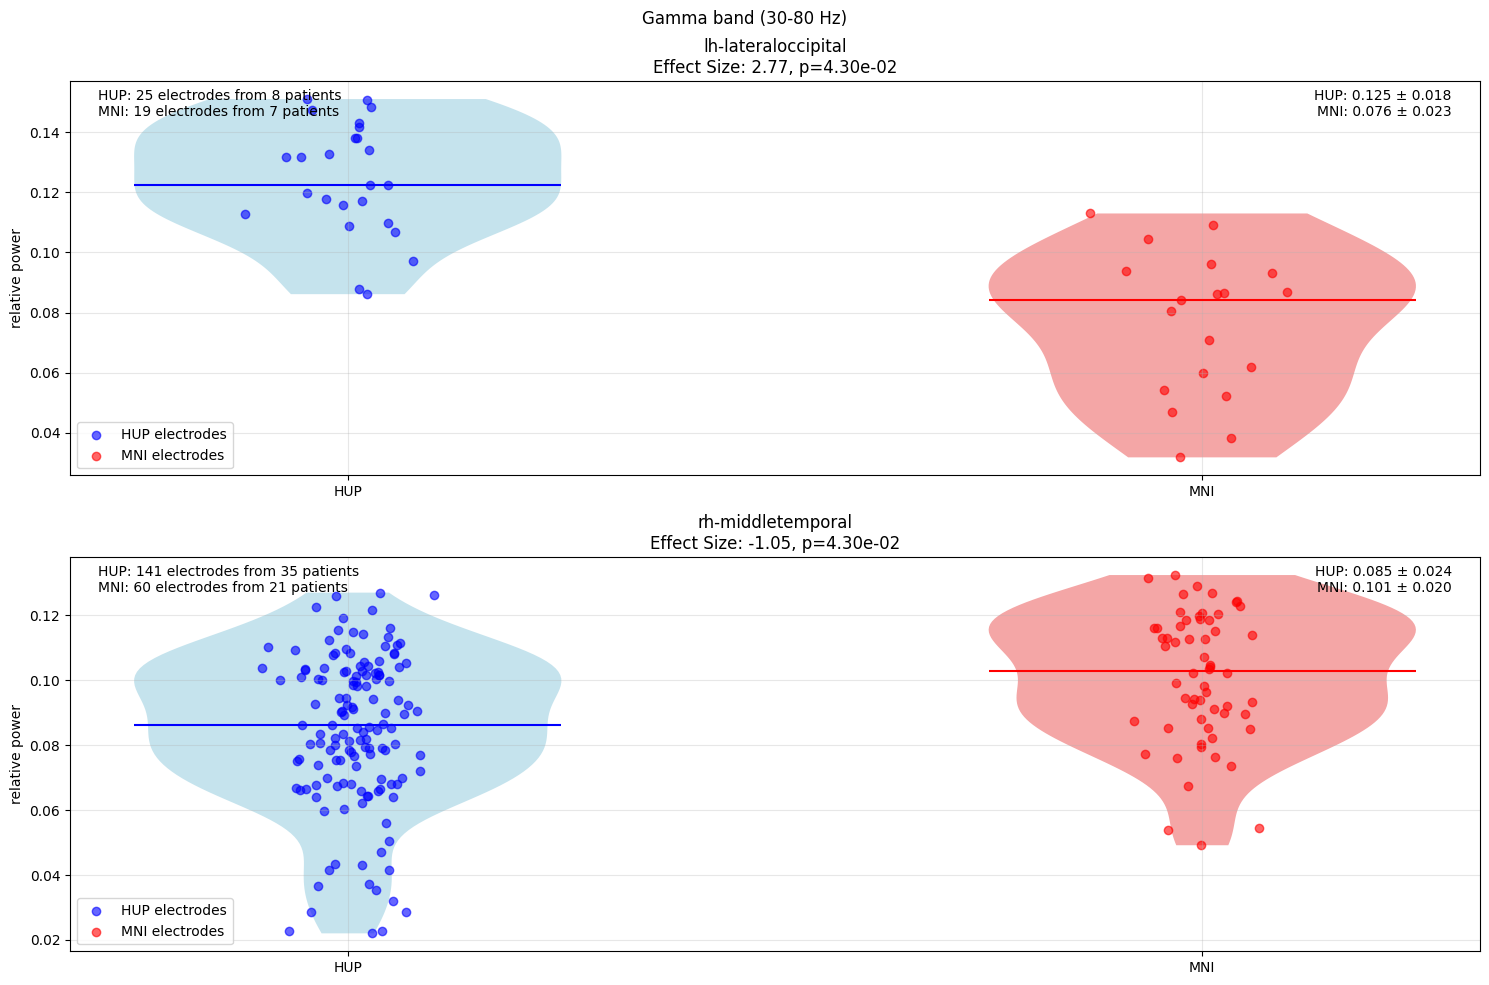

In [141]:
create_regional_comparison_plots(
    results_df=regional_results,
    hup_df=hup_df,
    mni_df=mni_df,
    hup_features=hup_univar_feats,
    mni_features=mni_univar_feats,
    hup_atlas=hup_atlas,
    mni_atlas=mni_atlas
)

In [98]:
def verify_patient_distributions(hup_df, mni_df, hup_atlas, mni_atlas):
    """
    Verify patient and electrode distributions across regions
    """
    # Get patient mappings
    mappings = get_patient_mappings(hup_atlas, mni_atlas, hup_df, mni_df)
    
    # Overall patient counts
    total_hup_patients = len(np.unique(hup_atlas['patient_no']))
    total_mni_patients = len(np.unique(mni_atlas['Patient']))
    
    print(f"Total unique patients in dataset:")
    print(f"HUP: {total_hup_patients}")
    print(f"MNI: {total_mni_patients}")
    
    # Get counts per region
    print("\nPatient distribution across regions:")
    for site, df, mapping in [('HUP', hup_df, mappings['hup']), 
                            ('MNI', mni_df, mappings['mni'])]:
        print(f"\n{site} regions:")
        
        for roi_num in sorted(df['roiNum'].unique()):
            region_mask = df['roiNum'] == roi_num
            electrodes = df[region_mask]
            patient_ids = mapping.loc[electrodes.index, 'patient_id']
            region_name = df[region_mask]['abvr'].iloc[0]
            
            print(f"{region_name:20s}: {len(electrodes):3d} electrodes from {len(patient_ids.unique()):2d} patients")
    
    # Verify superior temporal region specifically
    print("\nDetailed verification for superior temporal region:")
    for site, df, mapping in [('HUP', hup_df, mappings['hup']), 
                            ('MNI', mni_df, mappings['mni'])]:
        roi_mask = df['abvr'] == 'SpTmp_L'
        if any(roi_mask):
            roi_num = df[roi_mask]['roiNum'].iloc[0]
            electrodes = df[df['roiNum'] == roi_num]
            patient_ids = mapping.loc[electrodes.index, 'patient_id']
            
            print(f"\n{site}:")
            print(f"ROI number: {roi_num}")
            print(f"Number of electrodes: {len(electrodes)}")
            print(f"Number of patients: {len(patient_ids.unique())}")
            print(f"Patient IDs: {sorted(patient_ids.unique())}")
            
            # Distribution of electrodes per patient
            electrodes_per_patient = patient_ids.value_counts()
            print("\nElectrodes per patient:")
            print(electrodes_per_patient.describe())
            
            # Verify if patient numbers match total dataset
            dataset_patients = set(patient_ids.unique())
            all_patients = set(mapping['patient_id'].unique())
            print(f"\nPatients in this region represent {len(dataset_patients)/len(all_patients)*100:.1f}% of all patients")

# Run verification
verify_patient_distributions(hup_df, mni_df, hup_atlas, mni_atlas)

Total unique patients in dataset:
HUP: 60
MNI: 106

Patient distribution across regions:

HUP regions:
Tha_L               :   2 electrodes from  1 patients
Cau_L               :   9 electrodes from  5 patients
Put_L               :  14 electrodes from  8 patients
Pal_L               :   2 electrodes from  2 patients
Hip_L               : 127 electrodes from 38 patients
Amy_L               :  61 electrodes from 26 patients
Cau_R               :  12 electrodes from  5 patients
Put_R               :  20 electrodes from  9 patients
Pal_R               :   4 electrodes from  2 patients
Hip_R               : 148 electrodes from 41 patients
Amy_R               :  26 electrodes from 15 patients
Acc_R               :   3 electrodes from  3 patients
Bkst_L              :  21 electrodes from 11 patients
CaACg_L             :   2 electrodes from  1 patients
CaMFr_L             :  67 electrodes from 22 patients
Cun_L               :   2 electrodes from  2 patients
Ethr_L              :  13 electro